In [1]:
import glob
import os
import pandas as pd
import numpy as np
#from pycaret.time_series import TSForecastingExperiment
from sktime.transformations.series.summarize import WindowSummarizer
import pandas as pd

In [2]:
from pycaret.utils import version
version()

'3.3.2'

## Load training data

In [3]:
merged_ihfd_met= "/home/paulharford/college/project/project_data/processed/WEATHERED_merged_v2.csv"
full_path_merged = os.path.abspath(merged_ihfd_met)

In [4]:
merged_reg = pd.read_csv(full_path_merged)

In [5]:
# List of columns to drop
columns_to_drop = ['cold_lag', 'wind_lag', 'precip_lag', 'heat_lag','red_warning_lag','orange_warning_lag','no_adverse_weather']

# Drop the columns
merged_reg = merged_reg.drop(columns=columns_to_drop)

# Verify the columns were dropped
print(f"Shape after dropping columns: {merged_reg.shape}")

Shape after dropping columns: (97119, 29)


In [6]:
#['hip_fracture_event'] = (df_merged_train['hip_fracture_count'] > 0).astype(int)
merged_reg['has_weather_event'] = (merged_reg['weather_event'] > 0).astype(int)
merged_reg['hip_weather_interaction'] = merged_reg['hip_fracture_count'] * merged_reg['has_weather_event']


In [7]:
merged_reg['date'] = pd.to_datetime(merged_reg['date'])

In [8]:
merged_reg.head()

,region,date,age_group,gender,hip_fracture_count,weather_event,warning_phenomenon,warning_severity,warning_severity_numeric,counties_in_region,...,is_autumn,orange_warning,yellow_warning,red_warning,cold_weather,wind_weather,precipitation,heat_weather,has_weather_event,hip_weather_interaction
0,HSE Dublin and Midlands,2014-01-02,65-69,Female,1.0,1.0,Wind,Yellow,1.0,7,...,0,0,1,0,0,1,0,0,1,1.0
1,HSE Dublin and Midlands,2014-01-03,60-64,Female,0.0,1.0,Wind,Yellow,1.0,7,...,0,0,1,0,0,1,0,0,1,0.0
2,HSE Dublin and Midlands,2014-01-03,65-69,Female,0.0,1.0,Wind,Yellow,1.0,7,...,0,0,1,0,0,1,0,0,1,0.0
3,HSE Dublin and Midlands,2014-01-03,70-74,Female,0.0,1.0,Wind,Yellow,1.0,7,...,0,0,1,0,0,1,0,0,1,0.0
4,HSE Dublin and Midlands,2014-01-03,75-79,Female,0.0,1.0,Wind,Yellow,1.0,7,...,0,0,1,0,0,1,0,0,1,0.0


## Load and prepare 2024 data 

In [9]:
census_2024 = "/home/paulharford/college/project/project_data/processed/WEATHERED_census_estimated_2024_pop_age_grp_gender_region.csv"
full_path_census_2024 = os.path.abspath(census_2024)
weather_2024 = "/home/paulharford/college/project/project_data/processed/WEATHERED_warnings_2024_cleaned_v1.0.csv"
full_path_weather_2024 = os.path.abspath(weather_2024)

In [10]:
df_census_2024 = pd.read_csv(full_path_census_2024)

In [11]:
df_census_2024.head()

,region,date,age_group,female,male,total,year
0,HSE Dublin and Midlands,2024-01-01,60 - 64,26710,27835,54545,2024
1,HSE Dublin and Midlands,2024-01-02,60 - 64,26710,27835,54545,2024
2,HSE Dublin and Midlands,2024-01-03,60 - 64,26710,27835,54545,2024
3,HSE Dublin and Midlands,2024-01-04,60 - 64,26710,27835,54545,2024
4,HSE Dublin and Midlands,2024-01-05,60 - 64,26710,27835,54545,2024


In [12]:
df_weather_2024 = pd.read_csv(full_path_weather_2024)

In [13]:
##create 2024 datset columsn based on original data
# Create dataset with all regions, dates, age groups, and genders
regions = merged_reg['region'].unique()
age_groups = merged_reg['age_group'].unique()
genders = merged_reg['gender'].unique()

# Create dates for first 6 months of 2024
dates_2024 = pd.date_range(start='2024-01-01', end='2024-06-30', freq='D')

# Create the base combinations
base_rows = []
for region in regions:
    for date in dates_2024:
        for age_group in age_groups:
            for gender in genders:
                base_rows.append({
                    'region': region,
                    'date': date,
                    'age_group': age_group,
                    'gender': gender
                })

df_2024_base = pd.DataFrame(base_rows)

In [14]:
df_2024_base['date'] = pd.to_datetime(df_2024_base['date'])

In [15]:
# Add month
df_2024_base['month'] = df_2024_base['date'].dt.month

def assign_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Autumn'

df_2024_base['season'] = df_2024_base['month'].apply(assign_season)

# Add season indicator variables
df_2024_base['is_winter'] = (df_2024_base['season'] == 'Winter').astype(int)
df_2024_base['is_spring'] = (df_2024_base['season'] == 'Spring').astype(int)
df_2024_base['is_summer'] = (df_2024_base['season'] == 'Summer').astype(int)
df_2024_base['is_autumn'] = (df_2024_base['season'] == 'Autumn').astype(int)

In [16]:
# Create expanded population data with gender column
expanded_population = []

# For each row in your current population data
for _, row in df_census_2024.iterrows():
    # Create a row for females
    female_row = row.copy()
    female_row['gender'] = 'female'
    female_row['population'] = row['female']  # Set population to the female count
    
    # Create a row for males
    male_row = row.copy()
    male_row['gender'] = 'male'
    male_row['population'] = row['male']  # Set population to the male count
    
    # Add both rows to the expanded dataset
    expanded_population.append(female_row)
    expanded_population.append(male_row)

# Convert to DataFrame
df_census_2024_exp = pd.DataFrame(expanded_population)

In [17]:
df_census_2024_exp.head()

,region,date,age_group,female,male,total,year,gender,population
0,HSE Dublin and Midlands,2024-01-01,60 - 64,26710,27835,54545,2024,female,26710
0,HSE Dublin and Midlands,2024-01-01,60 - 64,26710,27835,54545,2024,male,27835
1,HSE Dublin and Midlands,2024-01-02,60 - 64,26710,27835,54545,2024,female,26710
1,HSE Dublin and Midlands,2024-01-02,60 - 64,26710,27835,54545,2024,male,27835
2,HSE Dublin and Midlands,2024-01-03,60 - 64,26710,27835,54545,2024,female,26710


In [18]:
def standardize_population_to_match_training(pop_df):
    import pandas as pd
    
    # Create a copy to avoid modifying the original
    pop_copy = pop_df.copy()
    
    # 1. Create a precise mapping for age groups to match training data format
    age_group_mapping = {
        '60 - 64': '60-64',
        '65 - 69': '65-69',
        '70 - 74': '70-74',
        '75 - 79': '75-79',
        '80 - 84': '80-84',
        '85 and over': '85 years and over'
    }
    
    # Apply mapping to population dataset
    pop_copy['age_group'] = pop_copy['age_group'].replace(age_group_mapping)
    
    # 2. Standardize gender (capitalize to match training data)
    pop_copy['gender'] = pop_copy['gender'].str.capitalize()
    
    # 3. Ensure dates are datetime objects for proper operations
    pop_copy['date'] = pd.to_datetime(pop_copy['date'])
    
    # 4. Strip any extra whitespace from region names
    if 'region' in pop_copy.columns:
        pop_copy['region'] = pop_copy['region'].str.strip()
    
    # 5. Calculate log_population if needed
    if 'population' in pop_copy.columns and 'log_population' not in pop_copy.columns:
        import numpy as np
        pop_copy['log_population'] = np.log(pop_copy['population'])
    
    return pop_copy

In [19]:
# Apply standardization to your expanded population dataset
population_data_2024_standardized = standardize_population_to_match_training(
    df_census_2024_exp
)

# Now merge with your base dataset
#df_merged = df_2024_base.merge(
#    population_data_2024_standardized,
#    on=['region', 'date', 'age_group', 'gender'],
#    how='left'
#)

# Check the merge results
print("NaN counts after merging:")
print(population_data_2024_standardized.isna().sum())
print(df_2024_base.isna().sum())

NaN counts after merging:
region            0
date              0
age_group         0
female            0
male              0
total             0
year              0
gender            0
population        0
log_population    0
dtype: int64
region       0
date         0
age_group    0
gender       0
month        0
season       0
is_winter    0
is_spring    0
is_summer    0
is_autumn    0
dtype: int64


In [20]:
# Merge the standardized datasets
df_merged_2024 = df_2024_base.merge(
    population_data_2024_standardized,
    on=['region', 'date', 'age_group', 'gender'],
    how='left'
)

# Verify the merge results
print("Shape of merged dataset:", df_merged_2024.shape)
print("NaN counts after merging:")
print(df_merged_2024.isna().sum())

Shape of merged dataset: (13104, 16)
NaN counts after merging:
region            0
date              0
age_group         0
gender            0
month             0
season            0
is_winter         0
is_spring         0
is_summer         0
is_autumn         0
female            0
male              0
total             0
year              0
population        0
log_population    0
dtype: int64


In [21]:
df_weather_2024.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 546 entries, 0 to 545
Data columns (total 43 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Issue Time                    546 non-null    object 
 1   Valid From                    546 non-null    object 
 2   Valid To                      546 non-null    object 
 3   Warning Colour                546 non-null    object 
 4   Warning Element               546 non-null    object 
 5   Warning Text                  546 non-null    object 
 6   Clare                         546 non-null    int64  
 7   Cork                          546 non-null    int64  
 8   Kerry                         546 non-null    int64  
 9   Limerick                      546 non-null    int64  
 10  Tipperary                     546 non-null    int64  
 11  Waterford                     546 non-null    int64  
 12  Carlow                        546 non-null    int64  
 13  Dubli

In [22]:
regions = df_weather_2024['region'].unique()
min_date = df_weather_2024['date'].min()
max_date = df_weather_2024['date'].max()

In [23]:
##create all dates for all years to merge with datasets so we can have days with and without events 
all_dates = pd.date_range(start=min_date, end=max_date, freq='D')
multi_index = pd.MultiIndex.from_product([regions, all_dates], names=['region', 'date'])
df_region_date = pd.DataFrame(index=multi_index).reset_index()

In [24]:
df_region_date_weather = df_region_date.copy()

In [25]:
##create a numerical mapping of the weather severity
severity_mapping = {
    'Yellow': 1,
    'Orange': 2,
    'Red': 3
}

df_weather_2024['warning_severity_numeric'] = df_weather_2024['warning_severity'].map(severity_mapping)

In [26]:
def aggregate_weather_data(df_weather, keep_columns=None):
    """
    Aggregate weather data by region, date, weather_type, and warning_severity while
    preserving specified additional columns.
    
    Args:
        df_weather: DataFrame containing weather data
        keep_columns: List of additional columns to preserve (beyond the groupby columns)
        
    Returns:
        Aggregated DataFrame with one row per unique region-date-weather_type-warning_severity combination
    """
    # Define default columns to keep if none provided
    if keep_columns is None:
        keep_columns = [
            'counties_in_region', 	
            'county_weight'	
         ]
    
    # Define all columns to group by
    group_cols = ['region', 'date', 'warning_phenomenon', 'warning_severity']
    
    # Define aggregation functions for numeric and other columns
    agg_dict = {
        'warning_severity_numeric': 'max'
    }
    
    # Add aggregation functions for additional columns to preserve
    for col in keep_columns:
        if col in df_weather.columns:
            # For string columns, take the first value (assuming they're the same within groups)
            if df_weather[col].dtype == 'object':
                agg_dict[col] = 'first'
            # For boolean or integer flags (like has_multiple_events, warning_upgraded)
            elif df_weather[col].dtype in ['bool', 'int64', 'int32']:
                agg_dict[col] = 'max'
            # For numeric columns, take the max
            elif pd.api.types.is_numeric_dtype(df_weather[col]):
                agg_dict[col] = 'max'
            # For datetime columns
            elif pd.api.types.is_datetime64_dtype(df_weather[col]):
                agg_dict[col] = 'max'
            # Default to first value for any other types
            else:
                agg_dict[col] = 'first'
    
    # Group by the specified columns and aggregate
    weather_agg = df_weather.groupby(group_cols, as_index=False).agg(agg_dict)
    
    # Add the weather flag column (set to 1 if there is any event)
    weather_agg['weather_event'] = 1
    
    return weather_agg

In [27]:
weather_agg = aggregate_weather_data(df_weather_2024)

In [28]:
weather_agg.head()

,region,date,warning_phenomenon,warning_severity,warning_severity_numeric,counties_in_region,county_weight,weather_event
0,HSE Dublin and Midlands,2024-01-07,Fog,Yellow,1,7,0.142857,1
1,HSE Dublin and Midlands,2024-01-08,Low-Temperature_Ice,Yellow,1,7,0.142857,1
2,HSE Dublin and Midlands,2024-01-14,Low-Temperature_Ice,Yellow,1,7,0.142857,1
3,HSE Dublin and Midlands,2024-01-15,Snow_Ice,Yellow,1,7,0.142857,1
4,HSE Dublin and Midlands,2024-01-16,Low-Temperature_Ice,Yellow,1,7,0.142857,1


In [29]:
df_region_date_weather['date'] = pd.to_datetime(df_region_date_weather['date'])

In [30]:
weather_agg['date'] = pd.to_datetime(weather_agg['date'])

In [31]:
df_weather_final = pd.merge(
    df_region_date_weather,    # all region-date combos
    weather_agg,               # your aggregated counts
    on=['region', 'date'],    # merge keys
    how='left'                # left-join so we keep all rows from df_region_date
)


In [32]:
# First, check the format of your weather data
print("Weather data format check:")
print("Columns:", df_weather_2024.columns)
print("Date sample:", df_weather_2024['date'].iloc[0], "Type:", type(df_weather_2024['date'].iloc[0]))
print("Unique regions:", df_weather_2024['region'].unique())

# Standardize the weather data to match your base dataset format
def standardize_weather_data(weather_df):
    """
    Standardize the weather dataset to match the format of the base dataset
    """
    weather_copy = weather_df.copy()
    
    # Ensure date is in datetime format
    weather_copy['date'] = pd.to_datetime(weather_copy['date'])
    
    # Strip any whitespace from region names
    if 'region' in weather_copy.columns:
        weather_copy['region'] = weather_copy['region'].str.strip()
    
    return weather_copy

# Apply standardization to weather data
weather_data_2024_std = standardize_weather_data(df_weather_final)

# Merge weather data with your already merged base+population dataset
df_merged_with_weather = df_merged_2024.merge(
    weather_data_2024_std,
    on=['region', 'date'],
    how='left'
)

# Check the merge results
print("\nMerged dataset with weather:")
print("Shape:", df_merged_with_weather.shape)
print("NaN counts:")
print(df_merged_with_weather.isna().sum())

Weather data format check:
Columns: Index(['Issue Time', 'Valid From', 'Valid To', 'Warning Colour',
       'Warning Element', 'Warning Text', 'Clare', 'Cork', 'Kerry', 'Limerick',
       'Tipperary', 'Waterford', 'Carlow', 'Dublin', 'Kildare', 'Kilkenny',
       'Laois', 'Longford', 'Louth', 'Meath', 'Offaly', 'Westmeath', 'Wexford',
       'Wicklow', 'Cavan', 'Donegal', 'Monaghan', 'Galway', 'Leitrim', 'Mayo',
       'Roscommon', 'Sligo', 'warning_phenomenon', 'warning_severity',
       'weather_type', 'Duration_hours', 'date', 'region',
       'counties_in_region', 'weather_event_density', 'county_weight',
       'affected_counties_count', 'affected_counties_proportion',
       'warning_severity_numeric'],
      dtype='object')
Date sample: 2024-12-06 Type: <class 'str'>
Unique regions: ['HSE Dublin and North East' 'HSE West and North West' 'HSE South West'
 'HSE Mid West' 'HSE Dublin and South East' 'HSE Dublin and Midlands']

Merged dataset with weather:
Shape: (13608, 22)
NaN cou

In [33]:
df_merged_with_weather['warning_severity_numeric'] = df_merged_with_weather['warning_severity_numeric'].fillna(0)

In [34]:
df_merged_with_weather['weather_event'] = df_merged_with_weather['weather_event'].fillna(0)

In [35]:
df_merged_with_weather['warning_phenomenon'] = df_merged_with_weather['warning_phenomenon'].fillna('no_weather_type')

In [36]:
df_merged_with_weather['warning_severity'] = df_merged_with_weather['warning_severity'].fillna('no_weather_severity')

In [37]:
# Create lagged variables based on warning severity
# First, create indicator for orange warnings
df_merged_with_weather['orange_warning'] = ((df_merged_with_weather['warning_severity'] == 'Orange') | 
                             (df_merged_with_weather['warning_severity_numeric'] == 2)).astype(int)

# Create indicator for red warnings
df_merged_with_weather['red_warning'] = ((df_merged_with_weather['warning_severity'] == 'Red') | 
                           (df_merged_with_weather['warning_severity_numeric'] == 3)).astype(int)

# Create indicator for red warnings
df_merged_with_weather['yellow_warning'] = ((df_merged_with_weather['warning_severity'] == 'Yellow') | 
                           (df_merged_with_weather['warning_severity_numeric'] == 1)).astype(int)


In [38]:
df_merged_with_weather['cold_weather'] = df_merged_with_weather['warning_phenomenon'].isin(
    ['Snow_Ice', 'Ice', 'Low-Temperature', 'Low-Temperature_Ice', 'Fog']).astype(int)

df_merged_with_weather['wind_weather'] = df_merged_with_weather['warning_phenomenon'].isin(['Wind']).astype(int)

df_merged_with_weather['precipitation'] = df_merged_with_weather['warning_phenomenon'].isin(
    ['Rainfall', 'Thunder', 'Hail']).astype(int)

df_merged_with_weather['heat_weather'] = df_merged_with_weather['warning_phenomenon'].isin(['High-Temperature']).astype(int)

df_merged_with_weather['no_adverse_weather'] = df_merged_with_weather['warning_phenomenon'].isin(
    ['no_weather_type']).astype(int)

In [39]:
print(df_merged_with_weather.isna().sum())

region                          0
date                            0
age_group                       0
gender                          0
month                           0
season                          0
is_winter                       0
is_spring                       0
is_summer                       0
is_autumn                       0
female                          0
male                            0
total                           0
year                            0
population                      0
log_population                  0
warning_phenomenon              0
warning_severity                0
warning_severity_numeric        0
counties_in_region          10224
county_weight               10224
weather_event                   0
orange_warning                  0
red_warning                     0
yellow_warning                  0
cold_weather                    0
wind_weather                    0
precipitation                   0
heat_weather                    0
no_adverse_wea

In [40]:
# Add has_weather_event indicator
df_merged_with_weather['has_weather_event'] = (~df_merged_with_weather['warning_phenomenon'].isin(['none', None])).astype(int)

# Add empty hip_fracture_count column (this will be what we're forecasting)
df_merged_with_weather['hip_fracture_count'] = np.nan

# Add hip_weather_interaction with zeros (since we don't have hip fracture data yet)
df_merged_with_weather['hip_weather_interaction'] = 0

# Verify all needed columns are now present
print("Checking if all required columns are now present...")
missing_columns = [col for col in merged_reg.columns if col not in df_merged_with_weather.columns]
print("Still missing:", missing_columns)


Checking if all required columns are now present...
Still missing: []


In [41]:
# Get columns from the full historical dataset (2014-2023)
historical_columns = set(merged_reg.columns)  

# Get columns from your new 2024 dataset
new_dataset_columns = set(df_merged_with_weather.columns)

# Find columns in historical but not in new dataset
missing_in_new = historical_columns - new_dataset_columns
print("Columns in historical dataset but missing in new dataset:")
for col in sorted(missing_in_new):
    print(f"- {col}")

# Find columns in new dataset but not in historical
extra_in_new = new_dataset_columns - historical_columns
print("\nColumns in new dataset but not in historical:")
for col in sorted(extra_in_new):
    print(f"- {col}")

Columns in historical dataset but missing in new dataset:

Columns in new dataset but not in historical:
- no_adverse_weather
- year


In [42]:
# Drop 'no_adverse_weather' and 'year' from the 2024 dataset (if they exist)
columns_to_drop = ['no_adverse_weather', 'year']
for col in columns_to_drop:
    if col in df_merged_with_weather.columns:
        df_merged_with_weather = df_merged_with_weather.drop(columns=col)
        print(f"Dropped column: {col}")

# Verify the current columns
print("Current columns in 2024 dataset:", df_merged_with_weather.columns.tolist())

Dropped column: no_adverse_weather
Dropped column: year
Current columns in 2024 dataset: ['region', 'date', 'age_group', 'gender', 'month', 'season', 'is_winter', 'is_spring', 'is_summer', 'is_autumn', 'female', 'male', 'total', 'population', 'log_population', 'warning_phenomenon', 'warning_severity', 'warning_severity_numeric', 'counties_in_region', 'county_weight', 'weather_event', 'orange_warning', 'red_warning', 'yellow_warning', 'cold_weather', 'wind_weather', 'precipitation', 'heat_weather', 'has_weather_event', 'hip_fracture_count', 'hip_weather_interaction']


In [43]:
# First, let's verify which values exist for each region
region_county_info = df_merged_with_weather[
    df_merged_with_weather['counties_in_region'].notna()
].groupby('region')[['counties_in_region', 'county_weight']].first()

print("County information by region:")
print(region_county_info)

# Now fill the missing values based on region
# First, create a mapping dictionary for each region
region_counties_mapping = df_merged_with_weather[
    df_merged_with_weather['counties_in_region'].notna()
].groupby('region')['counties_in_region'].first().to_dict()

region_weight_mapping = df_merged_with_weather[
    df_merged_with_weather['county_weight'].notna()
].groupby('region')['county_weight'].first().to_dict()

# Fill in the missing values using the mappings
df_merged_with_weather['counties_in_region'] = df_merged_with_weather.apply(
    lambda row: region_counties_mapping.get(row['region'], 0) 
                if pd.isna(row['counties_in_region']) else row['counties_in_region'],
    axis=1
)

df_merged_with_weather['county_weight'] = df_merged_with_weather.apply(
    lambda row: region_weight_mapping.get(row['region'], 0) 
                if pd.isna(row['county_weight']) else row['county_weight'],
    axis=1
)

# Verify that there are no more NaN values in these columns
print("\nMissing values after filling:")
print("counties_in_region:", df_merged_with_weather['counties_in_region'].isna().sum())
print("county_weight:", df_merged_with_weather['county_weight'].isna().sum())

County information by region:
                           counties_in_region  county_weight
region                                                      
HSE Dublin and Midlands                   7.0       0.142857
HSE Dublin and North East                 5.0       0.200000
HSE Dublin and South East                 7.0       0.142857
HSE Mid West                              3.0       0.333333
HSE South West                            2.0       0.500000
HSE West and North West                   6.0       0.166667

Missing values after filling:
counties_in_region: 0
county_weight: 0


In [44]:
df_merged_with_weather.head()

,region,date,age_group,gender,month,season,is_winter,is_spring,is_summer,is_autumn,...,orange_warning,red_warning,yellow_warning,cold_weather,wind_weather,precipitation,heat_weather,has_weather_event,hip_fracture_count,hip_weather_interaction
0,HSE Dublin and Midlands,2024-01-01,65-69,Female,1,Winter,1,0,0,0,...,0,0,0,0,0,0,0,1,NaN,0
1,HSE Dublin and Midlands,2024-01-01,65-69,Male,1,Winter,1,0,0,0,...,0,0,0,0,0,0,0,1,NaN,0
2,HSE Dublin and Midlands,2024-01-01,60-64,Female,1,Winter,1,0,0,0,...,0,0,0,0,0,0,0,1,NaN,0
3,HSE Dublin and Midlands,2024-01-01,60-64,Male,1,Winter,1,0,0,0,...,0,0,0,0,0,0,0,1,NaN,0
4,HSE Dublin and Midlands,2024-01-01,70-74,Female,1,Winter,1,0,0,0,...,0,0,0,0,0,0,0,1,NaN,0


In [45]:
# Group by year and demographic segments to see the trend
merged_reg['year'] = merged_reg['date'].dt.year
population_trends = merged_reg.groupby(['year', 'region', 'age_group', 'gender'])[['female', 'male']].mean()

# Calculate growth rates between consecutive years
growth_rates = {}
for region in merged_reg['region'].unique():
    for age_group in merged_reg['age_group'].unique():
        for gender in merged_reg['gender'].unique():
            # Get historical data for this segment
            segment_data = population_trends.xs((region, age_group, gender), level=(1, 2, 3))
            
            if len(segment_data) >= 2:  # Need at least 2 years to calculate growth
                # Calculate year-over-year growth rates
                if gender == 'Female':
                    pop_col = 'female'
                else:
                    pop_col = 'male'
                
                yearly_values = segment_data[pop_col]
                yearly_growth = yearly_values.pct_change().dropna()
                
                # Use average of last 3 years' growth, or whatever is available
                recent_growth = yearly_growth.tail(3).mean()
                growth_rates[(region, age_group, gender)] = recent_growth

In [46]:
# Group by year and demographic segments to see the trend
df_merged_with_weather['year'] = df_merged_with_weather['date'].dt.year
population_trends = df_merged_with_weather.groupby(['year', 'region', 'age_group', 'gender'])[['female', 'male']].mean()

# Calculate growth rates between consecutive years
growth_rates = {}
for region in df_merged_with_weather['region'].unique():
    for age_group in df_merged_with_weather['age_group'].unique():
        for gender in df_merged_with_weather['gender'].unique():
            # Get historical data for this segment
            segment_data = population_trends.xs((region, age_group, gender), level=(1, 2, 3))
            
            if len(segment_data) >= 2:  # Need at least 2 years to calculate growth
                # Calculate year-over-year growth rates
                if gender == 'Female':
                    pop_col = 'female'
                else:
                    pop_col = 'male'
                
                yearly_values = segment_data[pop_col]
                yearly_growth = yearly_values.pct_change().dropna()
                
                # Use average of last 3 years' growth, or whatever is available
                recent_growth = yearly_growth.tail(3).mean()
                growth_rates[(region, age_group, gender)] = recent_growth

In [47]:
# Get the most recent year in the data
latest_year = merged_reg['year'].max()

# Create a dataframe for 2024 projections
latest_data = merged_reg[merged_reg['year'] == latest_year].copy()
unique_segments = latest_data.drop_duplicates(['region', 'age_group', 'gender'])

# Create a template for 2024 data
forecast_segments = []
for _, row in unique_segments.iterrows():
    # Create a new row for 2024
    new_row = row.copy()
    
    # Project the population using growth rates
    growth_key = (row['region'], row['age_group'], row['gender'])
    if growth_key in growth_rates:
        growth_rate = growth_rates[growth_key]
        years_to_project = 2024 - latest_year
        
        if row['gender'] == 'Female':
            new_row['female'] = row['female'] * (1 + growth_rate) ** years_to_project
            new_row['male'] = 0
        else:
            new_row['female'] = 0
            new_row['male'] = row['male'] * (1 + growth_rate) ** years_to_project
        
        new_row['total'] = new_row['female'] + new_row['male']
        new_row['population'] = new_row['female'] + new_row['male']
    
    forecast_segments.append(new_row)

forecast_base = pd.DataFrame(forecast_segments)

In [48]:
def create_national_monthly_data(df):
    """
    Transform daily data into monthly national aggregates with weather patterns.
    
    Parameters:
    -----------
    df : DataFrame
        The raw daily data with hip fracture counts and weather indicators
        
    Returns:
    --------
    DataFrame
        Monthly aggregated data with hip fracture counts and weather metrics
    """
    # Step 1: Basic monthly aggregation of hip fractures and primary indicators
    national_monthly = df.groupby(pd.Grouper(key='date', freq='M')).agg({
        'hip_fracture_count': 'sum',         # Total fractures per month
        
        # Weather indicators (take maximum per day, then aggregate)
        'has_weather_event': 'max',          # Any weather event in the period
        'cold_weather': 'max',               # Any cold weather in the period
        'wind_weather': 'max',               # Any wind warning in the period
        'precipitation': 'max',              # Any precipitation warning in the period
        'heat_weather': 'max',               # Any heat warning in the period
        
        # Warning severities (maximum level reached in the period)
        'yellow_warning': 'max',             # Any yellow warnings
        'orange_warning': 'max',             # Any orange warnings
        'red_warning': 'max',                # Any red warnings
        'warning_severity_numeric': 'max',   # Maximum warning severity
    }).reset_index()
    
    # Step 2: Count days with different weather conditions
    # First, aggregate daily indicators with groupby to get daily maximums
    daily_weather = df.groupby('date').agg({
        'has_weather_event': 'max',
        'cold_weather': 'max',
        'wind_weather': 'max',
        'precipitation': 'max',
        'heat_weather': 'max',
        'yellow_warning': 'max',
        'orange_warning': 'max',
        'red_warning': 'max',
    }).reset_index()
    
    # Then count days per month where each condition was present
    monthly_weather_days = daily_weather.groupby(pd.Grouper(key='date', freq='M')).agg({
        'has_weather_event': 'sum',      # Count days with any weather event
        'cold_weather': 'sum',           # Count days with cold weather
        'wind_weather': 'sum',           # Count days with wind warnings
        'precipitation': 'sum',          # Count days with precipitation
        'heat_weather': 'sum',           # Count days with heat warnings
        'yellow_warning': 'sum',         # Count days with yellow warnings
        'orange_warning': 'sum',         # Count days with orange warnings
        'red_warning': 'sum',            # Count days with red warnings
    }).reset_index()
    
    # Rename columns to clarify these are day counts
    monthly_weather_days = monthly_weather_days.rename(columns={
        'has_weather_event': 'days_with_weather',
        'cold_weather': 'days_with_cold',
        'wind_weather': 'days_with_wind',
        'precipitation': 'days_with_precipitation',
        'heat_weather': 'days_with_heat',
        'yellow_warning': 'days_with_yellow',
        'orange_warning': 'days_with_orange',
        'red_warning': 'days_with_red',
    })
    
    # Step 3: Calculate consecutive days metrics
    def calc_consecutive_days(series):
        """Calculate maximum consecutive days with a condition"""
        if len(series) == 0:
            return 0
            
        # Convert to numpy for performance
        arr = series.values
        
        # Find runs of consecutive True values
        # First, identify where values change
        changes = np.diff(np.concatenate(([0], arr, [0])))
        
        # Start indices of consecutive sequences (where value changes from 0 to 1)
        starts = np.where(changes == 1)[0]
        
        # End indices of consecutive sequences (where value changes from 1 to 0)
        ends = np.where(changes == -1)[0]
        
        # Calculate lengths of all sequences
        lengths = ends - starts
        
        # Return maximum length (or 0 if no sequences found)
        return np.max(lengths) if lengths.size > 0 else 0
    
    # For each month, calculate max consecutive days for each condition
    consecutive_days = []
    
    # Group the daily data by month
    monthly_groups = daily_weather.groupby(pd.Grouper(key='date', freq='M'))
    
    # For each month, calculate the consecutive days metrics
    for month_date, month_data in monthly_groups:
        max_consecutive = {
            'date': month_date,
            'max_consecutive_weather': calc_consecutive_days(month_data['has_weather_event']),
            'max_consecutive_cold': calc_consecutive_days(month_data['cold_weather']),
            'max_consecutive_wind': calc_consecutive_days(month_data['wind_weather']),
            'max_consecutive_precipitation': calc_consecutive_days(month_data['precipitation']),
            'max_consecutive_heat': calc_consecutive_days(month_data['heat_weather']),
            'max_consecutive_yellow': calc_consecutive_days(month_data['yellow_warning']),
            'max_consecutive_orange': calc_consecutive_days(month_data['orange_warning']),
            'max_consecutive_red': calc_consecutive_days(month_data['red_warning']),
        }
        consecutive_days.append(max_consecutive)
    
    # Convert to dataframe
    consecutive_days_df = pd.DataFrame(consecutive_days)
    
    # Step 4: Merge all features together
    # First merge monthly counts with basic aggregation
    result = pd.merge(national_monthly, monthly_weather_days, on='date')
    
    # Then merge consecutive days metrics
    result = pd.merge(result, consecutive_days_df, on='date')
    
    # Step 5: Add month and season indicators
    result['month'] = result['date'].dt.month
    result['year'] = result['date'].dt.year
    
    # Add season based on month
    season_map = {
        12: 'Winter', 1: 'Winter', 2: 'Winter',
        3: 'Spring', 4: 'Spring', 5: 'Spring',
        6: 'Summer', 7: 'Summer', 8: 'Summer',
        9: 'Autumn', 10: 'Autumn', 11: 'Autumn'
    }
    result['season'] = result['month'].map(season_map)
    
    # Add cyclical encoding of month (captures seasonality)
    result['month_sin'] = np.sin(2 * np.pi * result['month'] / 12)
    result['month_cos'] = np.cos(2 * np.pi * result['month'] / 12)
    
    return result

In [49]:
def create_regional_monthly_data(df):
    """
    Transform daily data into monthly regional aggregates with weather patterns.
    
    This function groups data by region and month, calculating fracture counts
    and various weather metrics at the regional level. It captures both the
    occurrence and intensity of weather events in each region.
    
    Parameters:
    -----------
    df : DataFrame
        The raw daily data with hip fracture counts and weather indicators
        
    Returns:
    --------
    DataFrame
        Monthly aggregated data by region with hip fracture counts and weather metrics
    """
    # Step 1: Basic monthly aggregation by region
    regional_monthly = df.groupby(['region', pd.Grouper(key='date', freq='M')]).agg({
        'hip_fracture_count': 'sum',         # Total fractures per region per month
        'counties_in_region': 'mean',        # Number of counties in this region
        
        # Weather indicators (maximum per region per month)
        'has_weather_event': 'max',          # Any weather event in the region
        'cold_weather': 'max',               # Any cold weather in the region
        'wind_weather': 'max',               # Any wind warning in the region
        'precipitation': 'max',              # Any precipitation warning in the region
        'heat_weather': 'max',               # Any heat warning in the region
        
        # Warning severities (maximum level reached in the region)
        'yellow_warning': 'max',             # Any yellow warnings in the region
        'orange_warning': 'max',             # Any orange warnings in the region
        'red_warning': 'max',                # Any red warnings in the region
        'warning_severity_numeric': 'max',   # Maximum warning severity in the region
    }).reset_index()
    
    # Step 2: Count days with different weather conditions by region
    # First, we need daily maximums for each region
    daily_regional_weather = df.groupby(['region', 'date']).agg({
        'has_weather_event': 'max',
        'cold_weather': 'max',
        'wind_weather': 'max',
        'precipitation': 'max',
        'heat_weather': 'max',
        'yellow_warning': 'max',
        'orange_warning': 'max',
        'red_warning': 'max',
    }).reset_index()
    
    # For each region and month, count days with each condition
    regional_weather_days = daily_regional_weather.groupby(['region', pd.Grouper(key='date', freq='M')]).agg({
        'has_weather_event': 'sum',      # Count days with any weather event
        'cold_weather': 'sum',           # Count days with cold weather
        'wind_weather': 'sum',           # Count days with wind warnings
        'precipitation': 'sum',          # Count days with precipitation
        'heat_weather': 'sum',           # Count days with heat warnings
        'yellow_warning': 'sum',         # Count days with yellow warnings
        'orange_warning': 'sum',         # Count days with orange warnings
        'red_warning': 'sum',            # Count days with red warnings
    }).reset_index()
    
    # Rename columns to clarify these are day counts
    regional_weather_days = regional_weather_days.rename(columns={
        'has_weather_event': 'days_with_weather',
        'cold_weather': 'days_with_cold',
        'wind_weather': 'days_with_wind',
        'precipitation': 'days_with_precipitation',
        'heat_weather': 'days_with_heat',
        'yellow_warning': 'days_with_yellow',
        'orange_warning': 'days_with_orange',
        'red_warning': 'days_with_red',
    })
    
    # Step 3: Calculate consecutive days metrics for each region
    def calc_consecutive_days(series):
        """Calculate maximum consecutive days with a condition"""
        if len(series) == 0:
            return 0
            
        # Convert to numpy for performance
        arr = series.values
        
        # Find runs of consecutive True values
        changes = np.diff(np.concatenate(([0], arr, [0])))
        starts = np.where(changes == 1)[0]
        ends = np.where(changes == -1)[0]
        lengths = ends - starts
        
        return np.max(lengths) if lengths.size > 0 else 0
    
    # Initialize list to store consecutive day metrics
    consecutive_days = []
    
    # For each region and month, calculate consecutive days
    for region in df['region'].unique():
        # Filter data for this region
        region_data = daily_regional_weather[daily_regional_weather['region'] == region]
        
        # Group by month
        monthly_groups = region_data.groupby(pd.Grouper(key='date', freq='M'))
        
        # For each month, calculate consecutive day metrics
        for month_date, month_data in monthly_groups:
            if len(month_data) > 0:  # Ensure we have data for this month
                max_consecutive = {
                    'region': region,
                    'date': month_date,
                    'max_consecutive_weather': calc_consecutive_days(month_data['has_weather_event']),
                    'max_consecutive_cold': calc_consecutive_days(month_data['cold_weather']),
                    'max_consecutive_wind': calc_consecutive_days(month_data['wind_weather']),
                    'max_consecutive_precipitation': calc_consecutive_days(month_data['precipitation']),
                    'max_consecutive_heat': calc_consecutive_days(month_data['heat_weather']),
                    'max_consecutive_yellow': calc_consecutive_days(month_data['yellow_warning']),
                    'max_consecutive_orange': calc_consecutive_days(month_data['orange_warning']),
                    'max_consecutive_red': calc_consecutive_days(month_data['red_warning']),
                }
                consecutive_days.append(max_consecutive)
    
    # Convert to dataframe
    consecutive_days_df = pd.DataFrame(consecutive_days)
    
    # Step 4: Merge all features together
    # First merge basic aggregation with day counts
    result = pd.merge(regional_monthly, regional_weather_days, on=['region', 'date'])
    
    # Then merge consecutive days metrics
    if len(consecutive_days_df) > 0:
        result = pd.merge(result, consecutive_days_df, on=['region', 'date'])
    
    # Step 5: Add month and season indicators
    result['month'] = result['date'].dt.month
    result['year'] = result['date'].dt.year
    
    # Add season based on month
    season_map = {
        12: 'Winter', 1: 'Winter', 2: 'Winter',
        3: 'Spring', 4: 'Spring', 5: 'Spring',
        6: 'Summer', 7: 'Summer', 8: 'Summer',
        9: 'Autumn', 10: 'Autumn', 11: 'Autumn'
    }
    result['season'] = result['month'].map(season_map)
    
    # Add cyclical encoding of month (captures seasonality)
    result['month_sin'] = np.sin(2 * np.pi * result['month'] / 12)
    result['month_cos'] = np.cos(2 * np.pi * result['month'] / 12)
    
    # Step 6: Add region-specific metrics
    # Calculate fracture rate per region (per 100,000 population)
    if 'population' in df.columns:
        # First get the average population per region per month
        region_population = df.groupby(['region', pd.Grouper(key='date', freq='M')])['population'].mean().reset_index()
        region_population = region_population.rename(columns={'population': 'avg_population'})
        
        # Merge with the result
        result = pd.merge(result, region_population, on=['region', 'date'])
        
        # Calculate fracture rate
        result['fracture_rate'] = (result['hip_fracture_count'] / result['avg_population']) * 100000
    
    return result

In [50]:
def create_demographic_monthly_data(df):
    """
    Transform daily data into monthly demographic aggregates.
    
    This function groups data by age group, gender, and month, calculating
    fracture counts and relevant metrics for each demographic group.
    
    Parameters:
    -----------
    df : DataFrame
        The raw daily data with hip fracture counts and demographic indicators
        
    Returns:
    --------
    DataFrame
        Monthly aggregated data by demographic group
    """
    # Step 1: Group by age group, gender, and month
    demographic_monthly = df.groupby(['age_group', 'gender', pd.Grouper(key='date', freq='M')]).agg({
        'hip_fracture_count': 'sum',       # Sum fractures by demographic group
        
        # Weather indicators affect all demographic groups the same way within a time period
        'has_weather_event': 'max',
        'cold_weather': 'max',
        'wind_weather': 'max',
        'precipitation': 'max',
        'heat_weather': 'max',
    }).reset_index()
    
    # Step 2: Add broader age categories for more stable analysis
    # Define age risk categories
    def map_age_to_risk(age):
        if age in ['60-64', '65-69']:
            return 'Senior (60-69)'
        elif age in ['70-74', '75-79']:
            return 'Elderly (70-79)'
        elif age in ['80-84', '85 years and over']:
            return 'Very Elderly (80+)'
        else:
            return age  # Keep original if it doesn't match our categories
    
    demographic_monthly['age_category'] = demographic_monthly['age_group'].apply(map_age_to_risk)
    
    # Step 3: Calculate demographic-specific rates if population data is available
    if 'population' in df.columns:
        # Get population by demographic group
        demo_population = df.groupby(['age_group', 'gender', pd.Grouper(key='date', freq='M')])['population'].mean().reset_index()
        demo_population = demo_population.rename(columns={'population': 'avg_population'})
        
        # Merge with demographic data
        demographic_monthly = pd.merge(demographic_monthly, demo_population, 
                                      on=['age_group', 'gender', 'date'])
        
        # Calculate fracture rate per 100,000 in demographic group
        demographic_monthly['fracture_rate'] = (demographic_monthly['hip_fracture_count'] / 
                                               demographic_monthly['avg_population']) * 100000
    
    # Step 4: Add month and season indicators
    demographic_monthly['month'] = demographic_monthly['date'].dt.month
    demographic_monthly['year'] = demographic_monthly['date'].dt.year
    
    # Add season based on month
    season_map = {
        12: 'Winter', 1: 'Winter', 2: 'Winter',
        3: 'Spring', 4: 'Spring', 5: 'Spring',
        6: 'Summer', 7: 'Summer', 8: 'Summer',
        9: 'Autumn', 10: 'Autumn', 11: 'Autumn'
    }
    demographic_monthly['season'] = demographic_monthly['month'].map(season_map)
    
    # Add cyclical encoding of month
    demographic_monthly['month_sin'] = np.sin(2 * np.pi * demographic_monthly['month'] / 12)
    demographic_monthly['month_cos'] = np.cos(2 * np.pi * demographic_monthly['month'] / 12)
    
    return demographic_monthly

In [51]:
def calculate_consecutive_weather_days(df):
    """
    Calculate the maximum consecutive days for various weather conditions.
    
    This function analyzes daily weather data to identify patterns of
    consecutive days with various weather conditions. These metrics can
    reveal sustained weather events that may have cumulative effects
    on health outcomes.
    
    Parameters:
    -----------
    df : DataFrame
        Daily data with weather indicators
        
    Returns:
    --------
    DataFrame
        Monthly aggregated consecutive day metrics
    """
    # Helper function to calculate consecutive days
    def calc_consecutive_days(series):
        """Calculate maximum consecutive days with a condition"""
        if len(series) == 0:
            return 0
            
        # Convert to numpy for performance
        arr = series.values
        
        # Find runs of consecutive True values
        changes = np.diff(np.concatenate(([0], arr, [0])))
        starts = np.where(changes == 1)[0]
        ends = np.where(changes == -1)[0]
        lengths = ends - starts
        
        return np.max(lengths) if lengths.size > 0 else 0
    
    # Aggregate weather indicators at the daily level
    daily_weather = df.groupby('date').agg({
        'has_weather_event': 'max',
        'cold_weather': 'max',
        'wind_weather': 'max',
        'precipitation': 'max',
        'yellow_warning': 'max',
        'orange_warning': 'max',
        'red_warning': 'max',
    }).reset_index()
    
    # Calculate consecutive days metrics by month
    monthly_consecutive = daily_weather.groupby(pd.Grouper(key='date', freq='M')).apply(
        lambda x: pd.Series({
            'max_consecutive_weather_days': calc_consecutive_days(x['has_weather_event']),
            'max_consecutive_cold_days': calc_consecutive_days(x['cold_weather']),
            'max_consecutive_wind_days': calc_consecutive_days(x['wind_weather']),
            'max_consecutive_precip_days': calc_consecutive_days(x['precipitation']),
            'max_consecutive_yellow_days': calc_consecutive_days(x['yellow_warning']),
            'max_consecutive_orange_days': calc_consecutive_days(x['orange_warning']),
            'max_consecutive_red_days': calc_consecutive_days(x['red_warning']),
        })
    ).reset_index()
    
    return monthly_consecutive


def add_risk_level_aggregation(demographic_monthly):
    """
    Create an aggregation by risk level from demographic data.
    
    This function takes demographic monthly data and creates a new
    dataset aggregated by risk level, which categorizes age groups
    into clinically relevant risk tiers for hip fractures.
    
    Parameters:
    -----------
    demographic_monthly : DataFrame
        Monthly data aggregated by demographic groups
        
    Returns:
    --------
    DataFrame
        Monthly data aggregated by risk level
    """
    # Define risk levels for different age groups
    age_risk_mapping = {
        '60-64': 'Moderate Risk',
        '65-69': 'Moderate Risk',
        '70-74': 'High Risk',
        '75-79': 'High Risk',
        '80-84': 'Very High Risk',
        '85 years and over': 'Very High Risk'
    }
    
    # Make a copy to avoid modifying the original
    demographic_copy = demographic_monthly.copy()
    
    # Add risk level to demographic data
    demographic_copy['risk_level'] = demographic_copy['age_group'].map(age_risk_mapping)
    
    # Create age-risk level aggregations
    risk_monthly = demographic_copy.groupby(['risk_level', pd.Grouper(key='date', freq='M')]).agg({
        'hip_fracture_count': 'sum',
        'has_weather_event': 'max',
        'cold_weather': 'max',
        'wind_weather': 'max',
        'precipitation': 'max',
    }).reset_index()
    
    # Add month and seasonal indicators
    risk_monthly['month'] = risk_monthly['date'].dt.month
    risk_monthly['year'] = risk_monthly['date'].dt.year
    
    # Add cyclical encoding of month
    risk_monthly['month_sin'] = np.sin(2 * np.pi * risk_monthly['month'] / 12)
    risk_monthly['month_cos'] = np.cos(2 * np.pi * risk_monthly['month'] / 12)
    
    # Add season based on month
    season_map = {
        12: 'Winter', 1: 'Winter', 2: 'Winter',
        3: 'Spring', 4: 'Spring', 5: 'Spring',
        6: 'Summer', 7: 'Summer', 8: 'Summer',
        9: 'Autumn', 10: 'Autumn', 11: 'Autumn'
    }
    risk_monthly['season'] = risk_monthly['month'].map(season_map)
    
    # Add fracture rate if population data is available
    if 'avg_population' in demographic_copy.columns:
        # Aggregate population by risk level
        risk_population = demographic_copy.groupby(['risk_level', pd.Grouper(key='date', freq='M')])['avg_population'].sum().reset_index()
        
        # Merge with risk data
        risk_monthly = pd.merge(risk_monthly, risk_population, on=['risk_level', 'date'])
        
        # Calculate fracture rate per 100,000
        risk_monthly['fracture_rate'] = (risk_monthly['hip_fracture_count'] / risk_monthly['avg_population']) * 100000
    
    # Add hierarchy level identifier
    risk_monthly['level'] = 'Risk'
    risk_monthly['id'] = risk_monthly['risk_level']
    
    return risk_monthly


In [52]:
def create_hierarchical_data(df):
    """
    Create a comprehensive hierarchical dataset for hip fracture forecasting.
    
    This function uses a modular approach to create data at four levels:
    1. National level - monthly data for the entire country
    2. Regional level - monthly data broken down by region
    3. Demographic level - monthly data by age group and gender
    4. Risk level - monthly data aggregated by clinical risk categories
    
    Parameters:
    -----------
    df : DataFrame
        Raw daily data with hip fracture counts and indicators
        
    Returns:
    --------
    tuple
        (national_monthly, regional_monthly, demographic_monthly, risk_monthly)
    """
    # Import necessary libraries
    import pandas as pd
    import numpy as np
    
    # Step 1: Create national monthly data
    national_monthly = create_national_monthly_data(df)
    
    # Step 2: Add consecutive weather patterns to national data
    consecutive_weather = calculate_consecutive_weather_days(df)
    national_monthly = pd.merge(national_monthly, consecutive_weather, on='date')
    
    # Step 3: Create regional monthly data
    regional_monthly = create_regional_monthly_data(df)
    
    # Step 4: Create demographic monthly data
    demographic_monthly = create_demographic_monthly_data(df)
    
    # Step 5: Create risk level data
    risk_monthly = add_risk_level_aggregation(demographic_monthly)
    
    # Step 6: Add hierarchical identifiers to national and regional data
    # (demographic and risk already have these from their creation functions)
    national_monthly['level'] = 'National'
    national_monthly['id'] = 'Total'
    
    regional_monthly['level'] = 'Regional'
    regional_monthly['id'] = regional_monthly['region']
    
    demographic_monthly['level'] = 'Demographic'
    demographic_monthly['id'] = demographic_monthly['age_group'] + '_' + demographic_monthly['gender']
    
    return national_monthly, regional_monthly, demographic_monthly, risk_monthly

In [53]:
# Process training data
national_train, regional_train, demographic_train, risk_train = create_hierarchical_data(merged_reg)

# Process unseen data (2024)
national_unseen, regional_unseen, demographic_unseen, risk_unseen = create_hierarchical_data(df_merged_with_weather)

# Verify the data is consistent
print(f"National data: {national_train.shape} train, {national_unseen.shape} unseen")
print(f"Regional data: {regional_train.shape} train, {regional_unseen.shape} unseen")
print(f"Demographic data: {demographic_train.shape} train, {demographic_unseen.shape} unseen")
print(f"Risk-level data: {risk_train.shape} train, {risk_unseen.shape} unseen")

National data: (120, 41) train, (6, 41) unseen
Regional data: (720, 38) train, (36, 38) unseen
Demographic data: (1440, 19) train, (72, 19) unseen
Risk-level data: (360, 16) train, (18, 16) unseen


In [54]:
# For ARIMA, we need time series objects
from statsmodels.tsa.arima.model import ARIMA

# National level ARIMA
national_ts = national_train.set_index('date')['hip_fracture_count']

# Function to prepare Prophet data
def prepare_prophet_data(df, target='hip_fracture_count'):
    # Prophet requires columns named 'ds' and 'y'
    prophet_df = df.rename(columns={'date': 'ds', target: 'y'})
    
    # Add additional regressors
    exog_columns = ['days_with_cold', 'days_with_wind', 'days_with_precipitation',
                   'max_consecutive_weather_days', 'days_with_yellow', 
                   'days_with_orange', 'days_with_red']
    
    # Only keep columns that exist in the dataframe
    exog_columns = [col for col in exog_columns if col in prophet_df.columns]
    
    # Final dataframe with target and regressors
    return prophet_df[['ds', 'y'] + exog_columns]

# Prepare national data for Prophet
national_prophet = prepare_prophet_data(national_train)

# Prepare regional data for Prophet
regional_prophet = {}
for region in regional_train['region'].unique():
    region_data = regional_train[regional_train['region'] == region]
    regional_prophet[region] = prepare_prophet_data(region_data)

In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import pmdarima as pm
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score



## New features 

In [56]:
# Create more targeted interaction features
def create_enhanced_features(df):
    # Copy the dataframe to avoid modifying the original
    enhanced_df = df.copy()
    
    # Hip fracture and weather interaction (you already have this)
    enhanced_df['hip_weather_interaction'] = enhanced_df['hip_fracture_count'] * enhanced_df['has_weather_event']
    
    # Create age group categories for easier analysis
    age_groups = {
        'elderly': ['75-79', '80-84', '85 years and over'],
        'senior': ['60-64', '65-69', '70-74']
    }
    
    # Create gender-specific features
    enhanced_df['female_ratio'] = enhanced_df['female'] / (enhanced_df['female'] + enhanced_df['male'])
    
    # Create interaction between weather and demographic groups
    if 'age_group' in enhanced_df.columns:
        enhanced_df['elderly_weather'] = ((enhanced_df['age_group'].isin(age_groups['elderly'])) & 
                                         (enhanced_df['has_weather_event'] == 1)).astype(int)
        
        enhanced_df['senior_weather'] = ((enhanced_df['age_group'].isin(age_groups['senior'])) & 
                                        (enhanced_df['has_weather_event'] == 1)).astype(int)
    
    # Create seasonal interaction features
    enhanced_df['winter_weather'] = enhanced_df['is_winter'] * enhanced_df['has_weather_event']
    enhanced_df['cold_weather_intensity'] = enhanced_df['cold_weather'] * enhanced_df['warning_severity_numeric']
    
    # Create thresholds for extreme weather events (if warning_severity_numeric exists)
    if 'warning_severity_numeric' in enhanced_df.columns:
        enhanced_df['severe_weather_event'] = (enhanced_df['warning_severity_numeric'] >= 2).astype(int)
        enhanced_df['extreme_weather_event'] = (enhanced_df['warning_severity_numeric'] == 3).astype(int)
    
    return enhanced_df

In [57]:
def create_enhanced_monthly_data(df):
    # First create the enhanced features
    enhanced_df = create_enhanced_features(df)
    
    # Define aggregation functions for different feature types
    agg_functions = {
        'hip_fracture_count': 'sum',
        'hip_weather_interaction': 'sum',
        'has_weather_event': 'mean',  # Percentage of days with weather events
        'cold_weather': 'mean',       # Percentage of days with cold weather
        'yellow_warning': 'mean',     # Percentage of days with yellow warnings
        'orange_warning': 'mean',     # Percentage of days with orange warnings
        'red_warning': 'mean',        # Percentage of days with red warnings
        'female_ratio': 'mean',       # Average female ratio
        'winter_weather': 'mean',     # Percentage of winter days with weather events
        'severe_weather_event': 'mean', # Percentage of days with severe weather
        'extreme_weather_event': 'mean', # Percentage of days with extreme weather
    }
    
    # Only include columns that exist in the dataframe
    agg_columns = {col: func for col, func in agg_functions.items() 
                  if col in enhanced_df.columns}
    
    # Aggregate to monthly level
    monthly_df = enhanced_df.groupby(pd.Grouper(key='date', freq='M')).agg(agg_columns).reset_index()
    
    # Add month and season indicators
    monthly_df['month'] = monthly_df['date'].dt.month
    monthly_df['year'] = monthly_df['date'].dt.year
    
    # Add cyclical encoding of month
    monthly_df['month_sin'] = np.sin(2 * np.pi * monthly_df['month'] / 12)
    monthly_df['month_cos'] = np.cos(2 * np.pi * monthly_df['month'] / 12)
    
    return monthly_df

In [58]:
def create_lag_features(df, target_col='hip_fracture_count', lags=[1, 7, 30, 365]):
    """
    Create lag features for time series data
    
    Parameters:
    -----------
    df : DataFrame
        Time series data with a date column
    target_col : str
        Name of the target column to lag
    lags : list
        List of lag periods to create
        
    Returns:
    --------
    DataFrame
        DataFrame with added lag features
    """
    # Make a copy to avoid modifying the original
    df_with_lags = df.copy()
    
    # Ensure the dataframe is sorted by date
    if 'date' in df_with_lags.columns:
        df_with_lags = df_with_lags.sort_values('date')
    
    # Store NaN positions to restore later
    nan_mask = df_with_lags[target_col].isna()
    
    # Temporarily fill NaNs with 0 for calculating lags
    temp_values = df_with_lags[target_col].fillna(0)
    
    # Create each lag feature without modifying the original target column
    for lag in lags:
        lag_name = f'{target_col}_lag{lag}'
        df_with_lags[lag_name] = temp_values.shift(lag)
    
    # No need to restore NaNs to original column since we never modified it
    
    return df_with_lags

In [59]:
def analyze_prophet_components(model, forecast):
    """Analyze how different components contribute to the Prophet forecast"""
    
    # Extract components
    components = ['trend', 'yearly']
    
    # Plot the component contributions
    plt.figure(figsize=(14, 10))
    
    # Plot each component
    for i, component in enumerate(components, 1):
        if component in forecast.columns:
            plt.subplot(len(components) + 1, 1, i)
            plt.plot(forecast['ds'], forecast[component])
            plt.title(f'{component.capitalize()} Component')
            plt.grid(True, alpha=0.3)
    
    # Plot the final prediction
    plt.subplot(len(components) + 1, 1, len(components) + 1)
    plt.plot(forecast['ds'], forecast['yhat'], label='Forecast')
    
    # If we have actual values, plot them too
    if 'y' in forecast.columns:
        plt.plot(forecast['ds'], forecast['y'], 'k.', label='Actual')
    
    plt.title('Overall Forecast')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Calculate contribution percentages
    if len(components) > 0:
        component_ranges = {}
        for component in components:
            if component in forecast.columns:
                component_range = forecast[component].max() - forecast[component].min()
                component_ranges[component] = component_range
        
        total_range = sum(component_ranges.values())
        
        print("\nComponent Contribution Analysis:")
        for component, range_val in component_ranges.items():
            contribution = (range_val / total_range) * 100 if total_range > 0 else 0
            print(f"{component.capitalize()}: {contribution:.1f}% of forecast variation")

In [60]:
# Function to aggregate to monthly with both lags and enhanced features
def create_monthly_data_with_features(df, target_col='hip_fracture_count'):
    """Create monthly data with lag features and enhanced interactions"""
    # First add lag features
    lags = [1, 7, 30, 90, 365]  # Days to lag
    df_with_lags = create_lag_features(df, target_col, lags)
    
    # Then add enhanced features
    enhanced_df = create_enhanced_features(df_with_lags)
    
    # Define aggregation functions for different feature types
    agg_functions = {
        'hip_fracture_count': 'sum',
        'has_weather_event': 'mean',  # Percentage of days with weather events
        'cold_weather': 'mean',       # Percentage of days with cold weather
        'yellow_warning': 'mean',     # Percentage of days with yellow warnings
        'orange_warning': 'mean',     # Percentage of days with orange warnings
        'red_warning': 'mean',        # Percentage of days with red warnings
    }
    
    # Add lag features aggregation
    for lag in lags:
        lag_col = f'{target_col}_lag{lag}'
        if lag_col in enhanced_df.columns:
            agg_functions[lag_col] = 'mean'  # Use mean for the lagged values
    
    # Add enhanced features aggregation
    enhanced_aggs = {
        'hip_weather_interaction': 'sum',
        'female_ratio': 'mean',
        'winter_weather': 'mean',
        'cold_weather_intensity': 'mean',
        'severe_weather_event': 'mean',
        'extreme_weather_event': 'mean'
    }
    agg_functions.update(enhanced_aggs)
    
    # Only include columns that exist in the dataframe
    agg_columns = {col: func for col, func in agg_functions.items() 
                  if col in enhanced_df.columns}
    
    # Aggregate to monthly level
    monthly_df = enhanced_df.groupby(pd.Grouper(key='date', freq='M')).agg(agg_columns).reset_index()
    
    # Add month and season indicators
    monthly_df['month'] = monthly_df['date'].dt.month
    monthly_df['year'] = monthly_df['date'].dt.year
    
    # Add cyclical encoding of month
    monthly_df['month_sin'] = np.sin(2 * np.pi * monthly_df['month'] / 12)
    monthly_df['month_cos'] = np.cos(2 * np.pi * monthly_df['month'] / 12)
    
    return monthly_df

In [61]:
# Prepare the training data
def prepare_prophet_training_data(training_df):
    """Prepare the training data for Prophet"""
    
    # Create monthly data with lag features and enhanced interactions
    monthly_train = create_monthly_data_with_features(training_df)
    
    # Drop rows with NaN values from the lags at the beginning of the series
    monthly_train_clean = monthly_train.dropna()
    
    print(f"Training data shape after creating features: {monthly_train.shape}")
    print(f"Training data shape after removing NaN values: {monthly_train_clean.shape}")
    
    return monthly_train_clean

In [62]:
def train_prophet_with_features(monthly_train):
    """Train a Prophet model with lag features and enhanced interactions"""
    
    # Prepare data for Prophet
    prophet_df = monthly_train.rename(columns={'date': 'ds', 'hip_fracture_count': 'y'})
    
    # Define which features to use as regressors
    potential_regressors = [
        # Lag features
        'hip_fracture_count_lag30',   # Previous month
        'hip_fracture_count_lag90',   # Previous quarter
        'hip_fracture_count_lag365',  # Same month last year
        
        # Weather interactions
        'hip_weather_interaction',
        'winter_weather',
        'cold_weather_intensity',
        
        # Basic weather
        'has_weather_event',
        'cold_weather',
        'severe_weather_event',
        
        # Demographics
        'female_ratio',
        
        # Cyclical features
        'month_sin',
        'month_cos'
    ]
    
    # Only use regressors that exist in the dataframe
    regressors = [col for col in potential_regressors if col in prophet_df.columns]
    
    print(f"Using these regressors in Prophet model: {regressors}")
    
    # Initialize Prophet model
    model = Prophet(
        yearly_seasonality=True,         # Annual pattern
        weekly_seasonality=False,        # No weekly pattern for monthly data
        daily_seasonality=False,         # No daily pattern for monthly data
        seasonality_mode='multiplicative', # Multiplicative seasonality
        interval_width=0.95,            # 95% prediction intervals
        changepoint_prior_scale=0.05    # Flexibility for trend changes
    )
    
    # Add the regressors
    for regressor in regressors:
        model.add_regressor(regressor)
    
    # Fit the model
    model.fit(prophet_df)
    
    return model, regressors

In [63]:
def validate_prophet_model_with_monthly_splits(df_merged_train, n_splits=3, test_size_months=6):
    """
    Validate the Prophet model using monthly time-based splits
    
    Parameters:
    -----------
    df_merged_train : DataFrame
        The dataset with date and target variable (hip_fracture_count)
    n_splits : int
        Number of splits for time series cross-validation
    test_size_months : int
        Size of each test set in months
        
    Returns:
    --------
    dict with evaluation metrics, trained models, and forecasts
    """
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt
    from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
    
    # Sort the data by date
    df_sorted = df_merged_train.sort_values('date')
    
    # Extract month information
    df_sorted['month'] = df_sorted['date'].dt.to_period('M')
    
    # Get unique months in order
    unique_months = sorted(df_sorted['month'].unique())
    
    # Determine the total number of months available
    n_months = len(unique_months)
    print(f"Dataset contains {n_months} months of data")
    
    # Check if we have enough data for the requested splits
    total_required_months = n_splits * test_size_months
    if total_required_months > n_months:
        print(f"Warning: Not enough data for {n_splits} splits with {test_size_months} months each.")
        print(f"Reducing to {n_months // test_size_months} splits.")
        n_splits = max(1, n_months // test_size_months)
    
    # Calculate where to start the test sets
    # We want the test sets to end at the end of the data
    # So we calculate backwards from the end
    test_start_indices = []
    for i in range(n_splits):
        # Start from the end and move backwards
        test_start_idx = n_months - (i + 1) * test_size_months
        if test_start_idx < 0:
            # Not enough data for this split
            break
        test_start_indices.append(test_start_idx)
    
    # Reverse so we go chronologically
    test_start_indices.reverse()
    
    # Initialize storage for results
    results = {
        'models': [],
        'regressors': [],
        'forecasts': [],
        'metrics': [],
        'train_periods': [],
        'test_periods': []
    }
    
    # Create figure for all validation plots
    n_actual_splits = len(test_start_indices)
    fig, axes = plt.subplots(n_actual_splits, 1, figsize=(12, 6*n_actual_splits))
    if n_actual_splits == 1:
        axes = [axes]
    
    # Perform time series validation with the calculated splits
    for i, test_start_idx in enumerate(test_start_indices):
        # Define the months for this split
        train_months = unique_months[:test_start_idx]
        test_months = unique_months[test_start_idx:test_start_idx + test_size_months]
        
        if len(train_months) == 0 or len(test_months) == 0:
            print(f"Warning: Split {i+1} has empty train or test set. Skipping.")
            continue
        
        # Convert periods to timestamps for display
        train_start = train_months[0].to_timestamp()
        train_end = train_months[-1].to_timestamp()
        test_start = test_months[0].to_timestamp()
        test_end = test_months[-1].to_timestamp()
        
        print(f"\n--- Split {i+1}/{n_actual_splits} ---")
        print(f"Training period: {train_start.strftime('%Y-%m')} to {train_end.strftime('%Y-%m')}")
        print(f"Testing period: {test_start.strftime('%Y-%m')} to {test_end.strftime('%Y-%m')}")
        
        # Get training and test data based on months
        train_data = df_sorted[df_sorted['month'].isin(train_months)]
        test_data = df_sorted[df_sorted['month'].isin(test_months)]
        
        print(f"Training data shape: {train_data.shape}")
        print(f"Test data shape: {test_data.shape}")
        
        # Prepare training data with features
        monthly_train = prepare_prophet_training_data(train_data)
        
        # Train the model
        model, regressors = train_prophet_with_features(monthly_train)
        
        # Now prepare test data WITH the same lag features
        # We need to include the training data to calculate lags correctly
        combined_data = pd.concat([train_data, test_data]).sort_values('date')
        monthly_combined = create_monthly_data_with_features(combined_data)
        
        # Extract just the test period - using proper date filtering
        test_start_date = test_months[0].to_timestamp()
        test_end_date = (test_months[-1] + 1).to_timestamp() - pd.Timedelta(days=1)  # Last day of the month
        monthly_test = monthly_combined[(monthly_combined['date'] >= test_start_date) & 
                                      (monthly_combined['date'] <= test_end_date)]
        
        # Check if monthly_test is empty
        if len(monthly_test) == 0:
            print(f"Warning: No data found for test period. Skipping split {i+1}.")
            continue
        
        # Prepare for Prophet
        prophet_test = monthly_test.rename(columns={'date': 'ds', 'hip_fracture_count': 'y'})
        
        # Ensure all regressors exist in the test data
        for regressor in regressors:
            if regressor not in prophet_test.columns:
                print(f"Warning: Regressor {regressor} missing from test data. Setting to 0.")
                prophet_test[regressor] = 0
        
        # Make predictions
        test_forecast = model.predict(prophet_test)
        
        # Add actual values for comparison
        test_forecast['y'] = prophet_test['y'].values
        
        # Calculate metrics
        mae = mean_absolute_error(test_forecast['y'], test_forecast['yhat'])
        rmse = np.sqrt(mean_squared_error(test_forecast['y'], test_forecast['yhat']))
        r2 = r2_score(test_forecast['y'], test_forecast['yhat'])
        
        metrics = {
            'split': i+1,
            'mae': mae,
            'rmse': rmse,
            'r2': r2,
            'train_period': (train_start, train_end),
            'test_period': (test_start, test_end)
        }
        
        print(f"Prophet Model Performance on Test Data (Split {i+1}):")
        print(f"Mean Absolute Error: {mae:.2f}")
        print(f"Root Mean Squared Error: {rmse:.2f}")
        print(f"R² Score: {r2:.4f}")
        
        # Save results
        results['models'].append(model)
        results['regressors'].append(regressors)
        results['forecasts'].append(test_forecast)
        results['metrics'].append(metrics)
        results['train_periods'].append((train_start, train_end))
        results['test_periods'].append((test_start, test_end))
        
        # Plot forecast vs actuals for this split
        ax = axes[i]
        ax.plot(test_forecast['ds'], test_forecast['y'], 'ko', label='Actual')
        ax.plot(test_forecast['ds'], test_forecast['yhat'], 'b-', label='Forecast')
        
        # Add prediction interval
        ax.fill_between(test_forecast['ds'], 
                        test_forecast['yhat_lower'], 
                        test_forecast['yhat_upper'], 
                        color='blue', alpha=0.2)
        
        ax.set_title(f'Split {i+1}: Prophet Forecast (Test Period: {test_start.strftime("%Y-%m")} to {test_end.strftime("%Y-%m")})')
        ax.legend()
        ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Calculate and display average metrics across all splits
    if results['metrics']:
        avg_mae = np.mean([m['mae'] for m in results['metrics']])
        avg_rmse = np.mean([m['rmse'] for m in results['metrics']])
        # Filter out NaN R² values before calculating mean
        r2_values = [m['r2'] for m in results['metrics'] if not np.isnan(m['r2'])]
        if r2_values:
            avg_r2 = np.mean(r2_values)
            print("\n--- Average Performance Across All Splits ---")
            print(f"Mean Absolute Error: {avg_mae:.2f}")
            print(f"Root Mean Squared Error: {avg_rmse:.2f}")
            print(f"R² Score: {avg_r2:.4f}")
        else:
            print("\n--- Average Performance Across All Splits ---")
            print(f"Mean Absolute Error: {avg_mae:.2f}")
            print(f"Root Mean Squared Error: {avg_rmse:.2f}")
            print("R² Score: Could not be calculated (possibly constant values in test sets)")
    
    # Optionally plot component plots for the last model
    if results['models']:
        final_model = results['models'][-1]
        final_forecast = results['forecasts'][-1]
        fig = final_model.plot_components(final_forecast)
        plt.show()
    
    return results


def run_prophet_monthly_validation(df_merged_train, n_splits=3, test_size_months=6):
    """
    Convenience function to run prophet validation with monthly splits
    
    Parameters:
    -----------
    df_merged_train : DataFrame
        The dataset with date and target variable
    n_splits : int
        Number of splits for time series validation
    test_size_months : int
        Size of each test set in months
        
    Returns:
    --------
    Validation results
    """
    # Run the validation
    results = validate_prophet_model_with_monthly_splits(
        df_merged_train,
        n_splits=n_splits,
        test_size_months=test_size_months
    )
    
    return results

In [64]:
def train_final_model_and_forecast(df_merged_train, df_merged_unseen):
    """
    Train a model on all training data and forecast unseen data
    
    Parameters:
    -----------
    df_merged_train : DataFrame
        The complete training dataset
    df_merged_unseen : DataFrame
        The unseen data to forecast
        
    Returns:
    --------
    final_model, full_forecast, feature_importance
    """
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt
    from prophet import Prophet
    from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
    
    # Prepare monthly data with features for training
    monthly_train = create_monthly_data_with_features(df_merged_train)
    
    # Prepare for Prophet
    prophet_train = monthly_train.rename(columns={'date': 'ds', 'hip_fracture_count': 'y'})
    
    # Get list of all potential regressors 
    all_regressors = [col for col in prophet_train.columns 
                     if col not in ['ds', 'y', 'month', 'year']]
    
    # Train Prophet model with all regressors
    final_model = Prophet(
        yearly_seasonality=False,
        weekly_seasonality=False,
        daily_seasonality=False,
        seasonality_mode='multiplicative',
        interval_width=0.95
    )
    
    # Add custom monthly seasonality
    final_model.add_seasonality(
        name='monthly', 
        period=30.5, 
        fourier_order=5
    )
    
    # Add regressors
    for regressor in all_regressors:
        final_model.add_regressor(regressor)
    
    # Fit model
    final_model.fit(prophet_train)
    
    # Prepare unseen data with correct lag features
    combined_data = pd.concat([df_merged_train, df_merged_unseen]).sort_values('date')
    monthly_combined = create_monthly_data_with_features(combined_data)
    
    # Extract just the unseen period
    monthly_unseen = monthly_combined[monthly_combined['date'] >= df_merged_unseen['date'].min()]
    
    # Prepare for Prophet
    prophet_unseen = monthly_unseen.rename(columns={'date': 'ds', 'hip_fracture_count': 'y'})
    
    # Make predictions
    full_forecast = final_model.predict(prophet_unseen)
    
    # Add actual values for comparison
    full_forecast['y'] = prophet_unseen['y'].values
    
    # Calculate metrics
    mae = mean_absolute_error(full_forecast['y'], full_forecast['yhat'])
    rmse = np.sqrt(mean_squared_error(full_forecast['y'], full_forecast['yhat']))
    r2 = r2_score(full_forecast['y'], full_forecast['yhat'])
    
    print(f"\nFull Model Performance on Unseen 2024 Data:")
    print(f"Mean Absolute Error: {mae:.2f}")
    print(f"Root Mean Squared Error: {rmse:.2f}")
    print(f"R² Score: {r2:.4f}")
    
    # Print monthly actual vs forecasted values
    print("\nMonthly Actual and Forecasted Hip Fracture Rates (Full Model):")
    print("="*80)
    print(f"{'Month':<12} {'Actual':<10} {'Forecast':<10} {'Lower 95%':<12} {'Upper 95%':<12} {'Diff':<10} {'Diff %':<10}")
    print("-"*80)
    
    for i in range(len(full_forecast)):
        # Format date as YYYY-MM
        month = full_forecast['ds'].iloc[i].strftime('%Y-%m')
        actual = full_forecast['y'].iloc[i]
        forecast = full_forecast['yhat'].iloc[i]
        lower = full_forecast['yhat_lower'].iloc[i]
        upper = full_forecast['yhat_upper'].iloc[i]
        
        # Calculate difference and percentage difference
        diff = forecast - actual
        diff_pct = (diff / actual * 100) if actual != 0 else float('inf')
        
        print(f"{month:<12} {actual:<10.2f} {forecast:<10.2f} {lower:<12.2f} {upper:<12.2f} {diff:<10.2f} {diff_pct:<10.2f}%")
    
    # Calculate and print summary statistics
    actuals = full_forecast['y']
    forecasts = full_forecast['yhat']
    
    print("\nSummary Statistics (Full Model):")
    print(f"Actual:    Min: {actuals.min():.2f}, Max: {actuals.max():.2f}, Mean: {actuals.mean():.2f}, Median: {actuals.median():.2f}")
    print(f"Forecast:  Min: {forecasts.min():.2f}, Max: {forecasts.max():.2f}, Mean: {forecasts.mean():.2f}, Median: {forecasts.median():.2f}")
    
    # Visualize forecast vs actuals
    plt.figure(figsize=(12, 6))
    plt.plot(full_forecast['ds'], full_forecast['y'], 'ko', label='Actual')
    plt.plot(full_forecast['ds'], full_forecast['yhat'], 'r-', label='Forecast')
    plt.fill_between(full_forecast['ds'], 
                   full_forecast['yhat_lower'], 
                   full_forecast['yhat_upper'], 
                   color='red', alpha=0.2)
    plt.title('Full Data Model: Forecast for Unseen 2024 Data')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
    
    # Calculate feature importance through perturbation analysis
    feature_importance = calculate_perturbation_importance(
        final_model, prophet_unseen, all_regressors
    )
    
    return final_model, full_forecast, feature_importance

In [65]:
def calculate_perturbation_importance(model, test_data, features):
    """Calculate feature importance by perturbing each feature"""
    
    # Make baseline prediction
    baseline_forecast = model.predict(test_data)
    baseline_predictions = baseline_forecast['yhat'].values
    
    # Calculate impact of each feature
    feature_importance = {}
    
    for feature in features:
        if feature in test_data.columns:
            # Create a copy with this feature set to its mean
            modified_df = test_data.copy()
            feature_mean = modified_df[feature].mean()
            modified_df[feature] = feature_mean
            
            # Make predictions
            modified_forecast = model.predict(modified_df)
            modified_predictions = modified_forecast['yhat'].values
            
            # Calculate the impact
            impact = np.mean(np.abs(baseline_predictions - modified_predictions))
            feature_importance[feature] = impact
    
    # Create DataFrame and sort
    importance_df = pd.DataFrame({
        'Feature': list(feature_importance.keys()),
        'Importance': list(feature_importance.values())
    })
    
    # Add relative importance
    if len(importance_df) > 0 and importance_df['Importance'].sum() > 0:
        importance_df['Relative_Importance'] = (
            importance_df['Importance'] / importance_df['Importance'].sum() * 100
        )
        importance_df = importance_df.sort_values('Importance', ascending=False)
        
        # Visualize
        plt.figure(figsize=(12, 8))
        plt.barh(importance_df['Feature'], importance_df['Relative_Importance'])
        plt.xlabel('Relative Importance (%)')
        plt.ylabel('Feature')
        plt.title('Feature Importance by Perturbation')
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()
    else:
        print("No meaningful feature importance could be calculated")
    
    return importance_df

In [70]:
def forecast_with_best_model(best_model, best_regressors, df_merged_train, df_merged_unseen):
    """
    Use the best model from validation to forecast unseen data with weekly breakdown
    
    Parameters:
    -----------
    best_model : Prophet model
        The best performing model from cross-validation
    best_regressors : list
        The list of regressors used in the best model
    df_merged_train : DataFrame
        The complete training dataset
    df_merged_unseen : DataFrame
        The unseen data to forecast
        
    Returns:
    --------
    unseen_forecast, feature_importance
    """
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt
    from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
    
    # Check if we're dealing with 2024 data
    is_forecast_data = df_merged_unseen['date'].min().year >= 2024
    
    # Prepare unseen data with correct lag features
    # We need to include training data to calculate lags correctly
    combined_data = pd.concat([df_merged_train, df_merged_unseen]).sort_values('date')
    
    # For 2024 data, temporarily set hip_fracture_count to 0 for lag calculation
    if is_forecast_data:
        combined_data.loc[combined_data['date'] >= '2024-01-01', 'hip_fracture_count'] = 0
    
    monthly_combined = create_monthly_data_with_features(combined_data)
    
    # Extract just the unseen period
    monthly_unseen = monthly_combined[monthly_combined['date'] >= df_merged_unseen['date'].min()]
    
    # Prepare for Prophet
    prophet_unseen = monthly_unseen.rename(columns={'date': 'ds', 'hip_fracture_count': 'y'})
    
    # Ensure all regressors exist in the unseen data
    for regressor in best_regressors:
        if regressor not in prophet_unseen.columns:
            print(f"Warning: Regressor {regressor} missing from unseen data. Setting to 0.")
            prophet_unseen[regressor] = 0
    
    # Make predictions
    unseen_forecast = best_model.predict(prophet_unseen)
    
    # Add actual values for comparison
    unseen_forecast['y'] = prophet_unseen['y'].values
    
    # For 2024 forecasts, we don't need to calculate error metrics
    if is_forecast_data:
        print(f"\nBest Model Forecasts for 2024 Data:")
        # Skip error metrics for forecast data
    else:
        # Calculate metrics for validation data
        mae = mean_absolute_error(unseen_forecast['y'], unseen_forecast['yhat'])
        rmse = np.sqrt(mean_squared_error(unseen_forecast['y'], unseen_forecast['yhat']))
        r2 = r2_score(unseen_forecast['y'], unseen_forecast['yhat'])
        
        print(f"\nBest Model Performance on Unseen Data:")
        print(f"Mean Absolute Error: {mae:.2f}")
        print(f"Root Mean Squared Error: {rmse:.2f}")
        print(f"R² Score: {r2:.4f}")
    
    # Create weekly breakdown
    weekly_breakdown = create_weekly_breakdown(unseen_forecast, is_forecast_data)
    
    # Print weekly breakdown tables
    print_weekly_tables(weekly_breakdown, is_forecast_data)
    
    # Print original monthly summary
    print("\nMonthly Summary:")
    print("="*80)
    
    if is_forecast_data:
        # For 2024 forecast data, don't show actual values
        print(f"{'Month':<12} {'Forecast':<10} {'Lower 95%':<12} {'Upper 95%':<12}")
        print("-"*80)
        
        for i in range(len(unseen_forecast)):
            # Format date as YYYY-MM
            month = unseen_forecast['ds'].iloc[i].strftime('%Y-%m')
            forecast = unseen_forecast['yhat'].iloc[i]
            lower = unseen_forecast['yhat_lower'].iloc[i]
            upper = unseen_forecast['yhat_upper'].iloc[i]
            
            print(f"{month:<12} {forecast:<10.2f} {lower:<12.2f} {upper:<12.2f}")
    else:
        # For validation data, show actuals and differences
        print(f"{'Month':<12} {'Actual':<10} {'Forecast':<10} {'Lower 95%':<12} {'Upper 95%':<12} {'Diff':<10} {'Diff %':<10}")
        print("-"*80)
        
        for i in range(len(unseen_forecast)):
            # Format date as YYYY-MM
            month = unseen_forecast['ds'].iloc[i].strftime('%Y-%m')
            actual = unseen_forecast['y'].iloc[i]
            forecast = unseen_forecast['yhat'].iloc[i]
            lower = unseen_forecast['yhat_lower'].iloc[i]
            upper = unseen_forecast['yhat_upper'].iloc[i]
            
            # Calculate difference and percentage difference
            diff = forecast - actual
            diff_pct = (diff / actual * 100) if actual != 0 else float('inf')
            
            print(f"{month:<12} {actual:<10.2f} {forecast:<10.2f} {lower:<12.2f} {upper:<12.2f} {diff:<10.2f} {diff_pct:<10.2f}%")
    
    # Calculate and print summary statistics
    forecasts = unseen_forecast['yhat']
    
    if is_forecast_data:
        # For 2024 data, only show forecast statistics
        print("\nSummary Statistics:")
        print(f"Forecast:  Min: {forecasts.min():.2f}, Max: {forecasts.max():.2f}, Mean: {forecasts.mean():.2f}, Median: {forecasts.median():.2f}")
    else:
        # For validation data, show both actual and forecast statistics
        actuals = unseen_forecast['y']
        print("\nSummary Statistics:")
        print(f"Actual:    Min: {actuals.min():.2f}, Max: {actuals.max():.2f}, Mean: {actuals.mean():.2f}, Median: {actuals.median():.2f}")
        print(f"Forecast:  Min: {forecasts.min():.2f}, Max: {forecasts.max():.2f}, Mean: {forecasts.mean():.2f}, Median: {forecasts.median():.2f}")
    
    # Visualize forecast
    plt.figure(figsize=(12, 6))
    
    if not is_forecast_data:
        # For validation data, show actuals
        plt.plot(unseen_forecast['ds'], unseen_forecast['y'], 'ko', label='Actual')
    
    plt.plot(unseen_forecast['ds'], unseen_forecast['yhat'], 'b-', label='Forecast')
    plt.fill_between(unseen_forecast['ds'], 
                    unseen_forecast['yhat_lower'], 
                    unseen_forecast['yhat_upper'], 
                    color='blue', alpha=0.2)
    
    title = 'Best Validation Model: Forecast for 2024' if is_forecast_data else 'Best Validation Model: Forecast for Unseen Data'
    plt.title(title)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
    
    # Analyze forecast components
    fig = best_model.plot_components(unseen_forecast)
    plt.show()
    
    # Calculate feature importance through perturbation analysis
    feature_importance = calculate_perturbation_importance(
        best_model, prophet_unseen, best_regressors
    )
    
    return unseen_forecast, feature_importance



def create_weekly_breakdown(monthly_forecast, is_forecast_data):
    """
    Create weekly breakdown from monthly forecast data
    
    Parameters:
    -----------
    monthly_forecast : DataFrame
        Monthly forecast data from Prophet
    is_forecast_data : bool
        Whether this is future forecast data (no actuals)
        
    Returns:
    --------
    DataFrame with weekly breakdown
    """
    import pandas as pd
    import numpy as np
    
    weekly_data = []
    
    for i in range(len(monthly_forecast)):
        month_date = monthly_forecast['ds'].iloc[i]
        month_str = month_date.strftime('%Y-%m')
        
        # Get monthly values
        monthly_forecast_val = monthly_forecast['yhat'].iloc[i]
        monthly_lower = monthly_forecast['yhat_lower'].iloc[i]
        monthly_upper = monthly_forecast['yhat_upper'].iloc[i]
        
        if not is_forecast_data:
            monthly_actual = monthly_forecast['y'].iloc[i]
        
        # Divide monthly values by 4 for weekly estimates
        weekly_forecast = monthly_forecast_val / 4
        weekly_lower = monthly_lower / 4
        weekly_upper = monthly_upper / 4
        
        if not is_forecast_data:
            weekly_actual = monthly_actual / 4
        
        # Create data for each week
        week_data = {
            'Month': month_str,
            'Week 1': weekly_forecast,
            'Week 2': weekly_forecast,
            'Week 3': weekly_forecast,
            'Week 4': weekly_forecast,
            'Week 1 Lower': weekly_lower,
            'Week 2 Lower': weekly_lower,
            'Week 3 Lower': weekly_lower,
            'Week 4 Lower': weekly_lower,
            'Week 1 Upper': weekly_upper,
            'Week 2 Upper': weekly_upper,
            'Week 3 Upper': weekly_upper,
            'Week 4 Upper': weekly_upper,
            'Monthly Total': monthly_forecast_val,
            'Monthly Lower': monthly_lower,
            'Monthly Upper': monthly_upper
        }
        
        if not is_forecast_data:
            week_data.update({
                'Week 1 Actual': weekly_actual,
                'Week 2 Actual': weekly_actual,
                'Week 3 Actual': weekly_actual,
                'Week 4 Actual': weekly_actual,
                'Monthly Actual': monthly_actual
            })
        
        weekly_data.append(week_data)
    
    return pd.DataFrame(weekly_data)


def print_weekly_tables(weekly_breakdown, is_forecast_data):
    """
    Print formatted weekly breakdown tables
    
    Parameters:
    -----------
    weekly_breakdown : DataFrame
        Weekly breakdown data
    is_forecast_data : bool
        Whether this is future forecast data (no actuals)
    """
    
    # Combined table with forecasts and confidence intervals
    print("\nWeekly Breakdown - Combined View:")
    print("="*100)
    print(f"{'Month':<10} {'Week 1':<20} {'Week 2':<20} {'Week 3':<20} {'Week 4':<20} {'Monthly Total':<15}")
    print("-"*100)
    
    for _, row in weekly_breakdown.iterrows():
        month = row['Month']
        w1 = f"{row['Week 1']:.1f} ({row['Week 1 Lower']:.1f}-{row['Week 1 Upper']:.1f})"
        w2 = f"{row['Week 2']:.1f} ({row['Week 2 Lower']:.1f}-{row['Week 2 Upper']:.1f})"
        w3 = f"{row['Week 3']:.1f} ({row['Week 3 Lower']:.1f}-{row['Week 3 Upper']:.1f})"
        w4 = f"{row['Week 4']:.1f} ({row['Week 4 Lower']:.1f}-{row['Week 4 Upper']:.1f})"
        total = f"{row['Monthly Total']:.1f}"
        
        print(f"{month:<10} {w1:<20} {w2:<20} {w3:<20} {w4:<20} {total:<15}")
    
    # Separate tables for forecast values
    print("\nWeekly Breakdown - Forecast Values:")
    print("="*80)
    print(f"{'Month':<10} {'Week 1':<12} {'Week 2':<12} {'Week 3':<12} {'Week 4':<12} {'Monthly Total':<15}")
    print("-"*80)
    
    for _, row in weekly_breakdown.iterrows():
        month = row['Month']
        print(f"{month:<10} {row['Week 1']:<12.2f} {row['Week 2']:<12.2f} {row['Week 3']:<12.2f} {row['Week 4']:<12.2f} {row['Monthly Total']:<15.2f}")
    
    # Lower bounds table
    print("\nWeekly Breakdown - Lower 95% Confidence:")
    print("="*80)
    print(f"{'Month':<10} {'Week 1':<12} {'Week 2':<12} {'Week 3':<12} {'Week 4':<12} {'Monthly Total':<15}")
    print("-"*80)
    
    for _, row in weekly_breakdown.iterrows():
        month = row['Month']
        print(f"{month:<10} {row['Week 1 Lower']:<12.2f} {row['Week 2 Lower']:<12.2f} {row['Week 3 Lower']:<12.2f} {row['Week 4 Lower']:<12.2f} {row['Monthly Lower']:<15.2f}")
    
    # Upper bounds table
    print("\nWeekly Breakdown - Upper 95% Confidence:")
    print("="*80)
    print(f"{'Month':<10} {'Week 1':<12} {'Week 2':<12} {'Week 3':<12} {'Week 4':<12} {'Monthly Total':<15}")
    print("-"*80)
    
    for _, row in weekly_breakdown.iterrows():
        month = row['Month']
        print(f"{month:<10} {row['Week 1 Upper']:<12.2f} {row['Week 2 Upper']:<12.2f} {row['Week 3 Upper']:<12.2f} {row['Week 4 Upper']:<12.2f} {row['Monthly Upper']:<15.2f}")
    


def compare_models_on_unseen_data(df_merged_train, df_merged_unseen, n_splits=6, test_size_months=6):
    """
    Compare the best validation model with a model trained on all data
    
    Parameters:
    -----------
    df_merged_train : DataFrame
        The complete training dataset
    df_merged_unseen : DataFrame
        The unseen data to forecast
    n_splits : int
        Number of validation splits
    test_size_months : int
        Size of each test window in months
        
    Returns:
    --------
    dict with all results
    """
    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt
    from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
    
    # Run cross-validation to find the best model
    results = run_prophet_monthly_validation(
        df_merged_train, 
        n_splits=n_splits,
        test_size_months=test_size_months
    )
    
    # Find the best model based on R² score
    valid_r2_scores = [m['r2'] for m in results['metrics'] if not np.isnan(m['r2'])]
    if not valid_r2_scores:
        print("Warning: No valid R² scores found. Using the last model.")
        best_model_index = -1
    else:
        best_model_index = np.argmax(valid_r2_scores)
    
    best_model = results['models'][best_model_index]
    best_regressors = results['regressors'][best_model_index]
    best_period = results['train_periods'][best_model_index]
    
    print(f"\nBest model from validation:")
    print(f"Split {best_model_index + 1}, Training period: {best_period[0].strftime('%Y-%m')} to {best_period[1].strftime('%Y-%m')}")
    print(f"R² Score during validation: {results['metrics'][best_model_index]['r2']:.4f}")
    
    # Use the best model to forecast unseen data
    best_forecast, best_importance = forecast_with_best_model(
        best_model, best_regressors, df_merged_train, df_merged_unseen
    )
    
    # Also train a model on all data for comparison
    print("\nTraining model on all data for comparison...")
    final_model, full_forecast, full_importance = train_final_model_and_forecast(
        df_merged_train, df_merged_unseen
    )
    
    # Compare the two models
    plt.figure(figsize=(12, 6))
    plt.plot(best_forecast['ds'], best_forecast['y'], 'ko', label='Actual')
    plt.plot(best_forecast['ds'], best_forecast['yhat'], 'b-', label='Best Validation Model')
    plt.plot(full_forecast['ds'], full_forecast['yhat'], 'r--', label='Full Data Model')
    plt.title('Comparison: Best Validation Model vs Full Data Model')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
    
    # Combine feature importance from both models for comparison
    combined_importance = pd.DataFrame({
        'Feature': best_importance['Feature'],
        'Best Model Importance': best_importance['Importance'],
        'Full Model Importance': full_importance['Importance']
    })
    
    # Sort by the average importance
    combined_importance['Average'] = (combined_importance['Best Model Importance'] + 
                                      combined_importance['Full Model Importance']) / 2
    combined_importance = combined_importance.sort_values('Average', ascending=False)
    
    # Convert feature values to strings for plotting
    # This is the fix for the TypeError
    features_as_str = combined_importance['Feature'].astype(str).values
    
    # Plot comparative feature importance
    plt.figure(figsize=(10, 8))
    plt.barh(features_as_str, combined_importance['Best Model Importance'], 
             color='blue', alpha=0.6, label='Best Validation Model')
    plt.barh(features_as_str, combined_importance['Full Model Importance'], 
             color='red', alpha=0.6, label='Full Data Model')
    plt.xlabel('Importance')
    plt.title('Feature Importance Comparison')
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    return {
        'validation_results': results,
        'best_model': best_model,
        'best_regressors': best_regressors,
        'best_forecast': best_forecast,
        'best_importance': best_importance,
        'full_model': final_model,
        'full_forecast': full_forecast,
        'full_importance': full_importance
    }

10:30:30 - cmdstanpy - INFO - Chain [1] start processing


Dataset contains 120 months of data

--- Split 1/12 ---
Training period: 2014-01 to 2020-12
Testing period: 2021-01 to 2021-03
Training data shape: (70207, 32)
Test data shape: (2162, 32)
Training data shape after creating features: (84, 22)
Training data shape after removing NaN values: (84, 22)
Using these regressors in Prophet model: ['hip_fracture_count_lag30', 'hip_fracture_count_lag90', 'hip_fracture_count_lag365', 'hip_weather_interaction', 'winter_weather', 'cold_weather_intensity', 'has_weather_event', 'cold_weather', 'severe_weather_event', 'female_ratio', 'month_sin', 'month_cos']


10:30:31 - cmdstanpy - INFO - Chain [1] done processing
10:30:31 - cmdstanpy - INFO - Chain [1] start processing


Prophet Model Performance on Test Data (Split 1):
Mean Absolute Error: 14.72
Root Mean Squared Error: 24.36
R² Score: -0.5593

--- Split 2/12 ---
Training period: 2014-01 to 2021-03
Testing period: 2021-04 to 2021-06
Training data shape: (72369, 32)
Test data shape: (2288, 32)
Training data shape after creating features: (87, 22)
Training data shape after removing NaN values: (87, 22)
Using these regressors in Prophet model: ['hip_fracture_count_lag30', 'hip_fracture_count_lag90', 'hip_fracture_count_lag365', 'hip_weather_interaction', 'winter_weather', 'cold_weather_intensity', 'has_weather_event', 'cold_weather', 'severe_weather_event', 'female_ratio', 'month_sin', 'month_cos']


10:30:31 - cmdstanpy - INFO - Chain [1] done processing
10:30:31 - cmdstanpy - INFO - Chain [1] start processing


Prophet Model Performance on Test Data (Split 2):
Mean Absolute Error: 14.15
Root Mean Squared Error: 18.61
R² Score: 0.4451

--- Split 3/12 ---
Training period: 2014-01 to 2021-06
Testing period: 2021-07 to 2021-09
Training data shape: (74657, 32)
Test data shape: (2180, 32)
Training data shape after creating features: (90, 22)
Training data shape after removing NaN values: (90, 22)
Using these regressors in Prophet model: ['hip_fracture_count_lag30', 'hip_fracture_count_lag90', 'hip_fracture_count_lag365', 'hip_weather_interaction', 'winter_weather', 'cold_weather_intensity', 'has_weather_event', 'cold_weather', 'severe_weather_event', 'female_ratio', 'month_sin', 'month_cos']


10:30:31 - cmdstanpy - INFO - Chain [1] done processing
10:30:31 - cmdstanpy - INFO - Chain [1] start processing


Prophet Model Performance on Test Data (Split 3):
Mean Absolute Error: 10.10
Root Mean Squared Error: 11.28
R² Score: 0.4961

--- Split 4/12 ---
Training period: 2014-01 to 2021-09
Testing period: 2021-10 to 2021-12
Training data shape: (76837, 32)
Test data shape: (2265, 32)
Training data shape after creating features: (93, 22)
Training data shape after removing NaN values: (93, 22)
Using these regressors in Prophet model: ['hip_fracture_count_lag30', 'hip_fracture_count_lag90', 'hip_fracture_count_lag365', 'hip_weather_interaction', 'winter_weather', 'cold_weather_intensity', 'has_weather_event', 'cold_weather', 'severe_weather_event', 'female_ratio', 'month_sin', 'month_cos']


10:30:32 - cmdstanpy - INFO - Chain [1] done processing
10:30:32 - cmdstanpy - INFO - Chain [1] start processing


Prophet Model Performance on Test Data (Split 4):
Mean Absolute Error: 17.25
Root Mean Squared Error: 23.35
R² Score: -1.3757

--- Split 5/12 ---
Training period: 2014-01 to 2021-12
Testing period: 2022-01 to 2022-03
Training data shape: (79102, 32)
Test data shape: (1976, 32)
Training data shape after creating features: (96, 22)
Training data shape after removing NaN values: (96, 22)
Using these regressors in Prophet model: ['hip_fracture_count_lag30', 'hip_fracture_count_lag90', 'hip_fracture_count_lag365', 'hip_weather_interaction', 'winter_weather', 'cold_weather_intensity', 'has_weather_event', 'cold_weather', 'severe_weather_event', 'female_ratio', 'month_sin', 'month_cos']


10:30:32 - cmdstanpy - INFO - Chain [1] done processing
10:30:32 - cmdstanpy - INFO - Chain [1] start processing


Prophet Model Performance on Test Data (Split 5):
Mean Absolute Error: 12.42
Root Mean Squared Error: 13.29
R² Score: 0.8200

--- Split 6/12 ---
Training period: 2014-01 to 2022-03
Testing period: 2022-04 to 2022-06
Training data shape: (81078, 32)
Test data shape: (2177, 32)
Training data shape after creating features: (99, 22)
Training data shape after removing NaN values: (99, 22)
Using these regressors in Prophet model: ['hip_fracture_count_lag30', 'hip_fracture_count_lag90', 'hip_fracture_count_lag365', 'hip_weather_interaction', 'winter_weather', 'cold_weather_intensity', 'has_weather_event', 'cold_weather', 'severe_weather_event', 'female_ratio', 'month_sin', 'month_cos']


10:30:33 - cmdstanpy - INFO - Chain [1] done processing
10:30:33 - cmdstanpy - INFO - Chain [1] start processing
10:30:33 - cmdstanpy - INFO - Chain [1] done processing


Prophet Model Performance on Test Data (Split 6):
Mean Absolute Error: 15.32
Root Mean Squared Error: 18.61
R² Score: -0.2167

--- Split 7/12 ---
Training period: 2014-01 to 2022-06
Testing period: 2022-07 to 2022-09
Training data shape: (83255, 32)
Test data shape: (2448, 32)
Training data shape after creating features: (102, 22)
Training data shape after removing NaN values: (102, 22)
Using these regressors in Prophet model: ['hip_fracture_count_lag30', 'hip_fracture_count_lag90', 'hip_fracture_count_lag365', 'hip_weather_interaction', 'winter_weather', 'cold_weather_intensity', 'has_weather_event', 'cold_weather', 'severe_weather_event', 'female_ratio', 'month_sin', 'month_cos']
Prophet Model Performance on Test Data (Split 7):
Mean Absolute Error: 11.63
Root Mean Squared Error: 12.64
R² Score: 0.6750

--- Split 8/12 ---
Training period: 2014-01 to 2022-09
Testing period: 2022-10 to 2022-12
Training data shape: (85703, 32)
Test data shape: (2355, 32)
Training data shape after creati

10:30:33 - cmdstanpy - INFO - Chain [1] start processing
10:30:33 - cmdstanpy - INFO - Chain [1] done processing
10:30:33 - cmdstanpy - INFO - Chain [1] start processing
10:30:33 - cmdstanpy - INFO - Chain [1] done processing


Prophet Model Performance on Test Data (Split 8):
Mean Absolute Error: 15.34
Root Mean Squared Error: 16.62
R² Score: 0.9416

--- Split 9/12 ---
Training period: 2014-01 to 2022-12
Testing period: 2023-01 to 2023-03
Training data shape: (88058, 32)
Test data shape: (2030, 32)
Training data shape after creating features: (108, 22)
Training data shape after removing NaN values: (108, 22)
Using these regressors in Prophet model: ['hip_fracture_count_lag30', 'hip_fracture_count_lag90', 'hip_fracture_count_lag365', 'hip_weather_interaction', 'winter_weather', 'cold_weather_intensity', 'has_weather_event', 'cold_weather', 'severe_weather_event', 'female_ratio', 'month_sin', 'month_cos']
Prophet Model Performance on Test Data (Split 9):
Mean Absolute Error: 13.71
Root Mean Squared Error: 14.27
R² Score: 0.7197

--- Split 10/12 ---
Training period: 2014-01 to 2023-03
Testing period: 2023-04 to 2023-06
Training data shape: (90088, 32)
Test data shape: (2067, 32)


10:30:33 - cmdstanpy - INFO - Chain [1] start processing
10:30:33 - cmdstanpy - INFO - Chain [1] done processing
10:30:33 - cmdstanpy - INFO - Chain [1] start processing
10:30:33 - cmdstanpy - INFO - Chain [1] done processing


Training data shape after creating features: (111, 22)
Training data shape after removing NaN values: (111, 22)
Using these regressors in Prophet model: ['hip_fracture_count_lag30', 'hip_fracture_count_lag90', 'hip_fracture_count_lag365', 'hip_weather_interaction', 'winter_weather', 'cold_weather_intensity', 'has_weather_event', 'cold_weather', 'severe_weather_event', 'female_ratio', 'month_sin', 'month_cos']
Prophet Model Performance on Test Data (Split 10):
Mean Absolute Error: 8.76
Root Mean Squared Error: 13.02
R² Score: 0.4438

--- Split 11/12 ---
Training period: 2014-01 to 2023-06
Testing period: 2023-07 to 2023-09
Training data shape: (92155, 32)
Test data shape: (2414, 32)
Training data shape after creating features: (114, 22)
Training data shape after removing NaN values: (114, 22)
Using these regressors in Prophet model: ['hip_fracture_count_lag30', 'hip_fracture_count_lag90', 'hip_fracture_count_lag365', 'hip_weather_interaction', 'winter_weather', 'cold_weather_intensity',

10:30:34 - cmdstanpy - INFO - Chain [1] start processing
10:30:34 - cmdstanpy - INFO - Chain [1] done processing


Prophet Model Performance on Test Data (Split 11):
Mean Absolute Error: 3.60
Root Mean Squared Error: 3.94
R² Score: 0.9799

--- Split 12/12 ---
Training period: 2014-01 to 2023-09
Testing period: 2023-10 to 2023-12
Training data shape: (94569, 32)
Test data shape: (2550, 32)
Training data shape after creating features: (117, 22)
Training data shape after removing NaN values: (117, 22)
Using these regressors in Prophet model: ['hip_fracture_count_lag30', 'hip_fracture_count_lag90', 'hip_fracture_count_lag365', 'hip_weather_interaction', 'winter_weather', 'cold_weather_intensity', 'has_weather_event', 'cold_weather', 'severe_weather_event', 'female_ratio', 'month_sin', 'month_cos']
Prophet Model Performance on Test Data (Split 12):
Mean Absolute Error: 10.09
Root Mean Squared Error: 11.61
R² Score: 0.9448


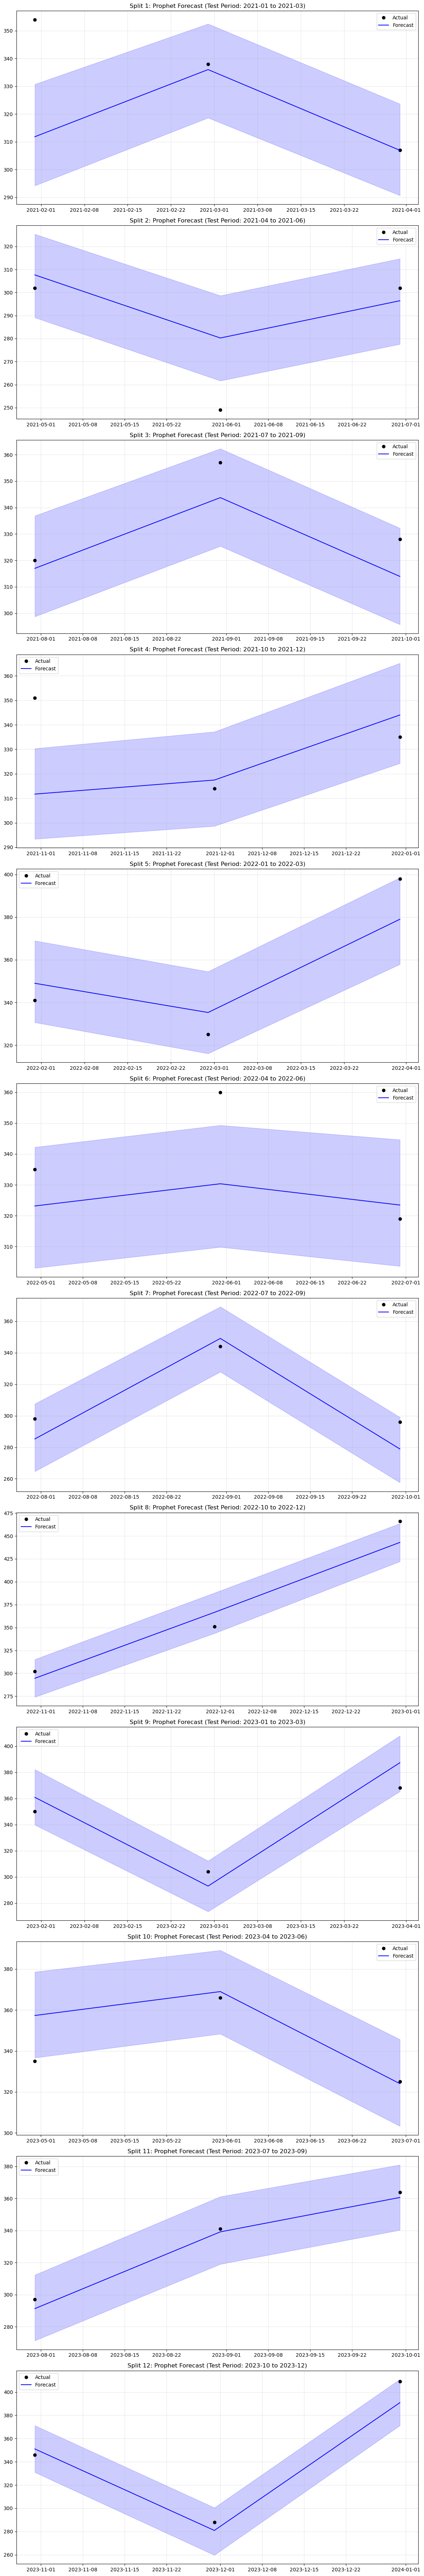


--- Average Performance Across All Splits ---
Mean Absolute Error: 12.26
Root Mean Squared Error: 15.13
R² Score: 0.3595


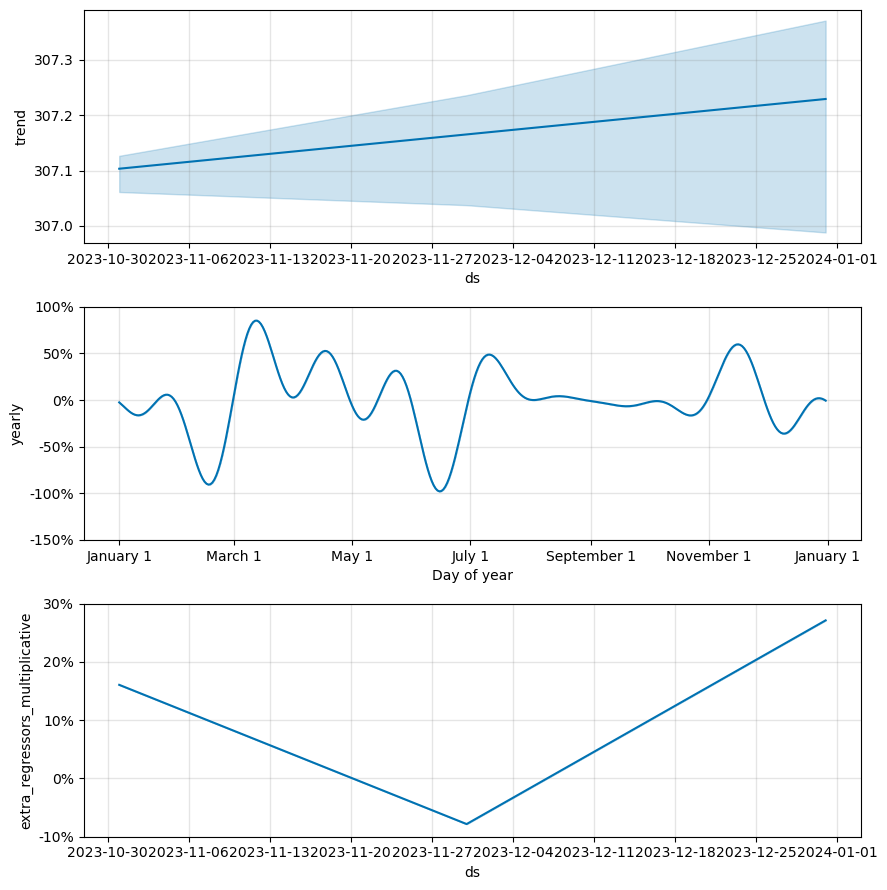


Best model from validation:
Split 11, Training period: 2014-01 to 2023-06
R² Score during validation: 0.9799

Best Model Forecasts for 2024 Data:

Weekly Breakdown - Combined View:
Month      Week 1               Week 2               Week 3               Week 4               Monthly Total  
----------------------------------------------------------------------------------------------------
2024-01    56.8 (51.0-62.3)     56.8 (51.0-62.3)     56.8 (51.0-62.3)     56.8 (51.0-62.3)     227.3          
2024-02    52.6 (47.5-57.3)     52.6 (47.5-57.3)     52.6 (47.5-57.3)     52.6 (47.5-57.3)     210.3          
2024-03    44.7 (39.8-49.9)     44.7 (39.8-49.9)     44.7 (39.8-49.9)     44.7 (39.8-49.9)     178.9          
2024-04    40.1 (35.0-45.2)     40.1 (35.0-45.2)     40.1 (35.0-45.2)     40.1 (35.0-45.2)     160.5          
2024-05    43.0 (38.3-47.6)     43.0 (38.3-47.6)     43.0 (38.3-47.6)     43.0 (38.3-47.6)     172.1          
2024-06    45.0 (40.0-49.8)     45.0 (40.0-49.8)   

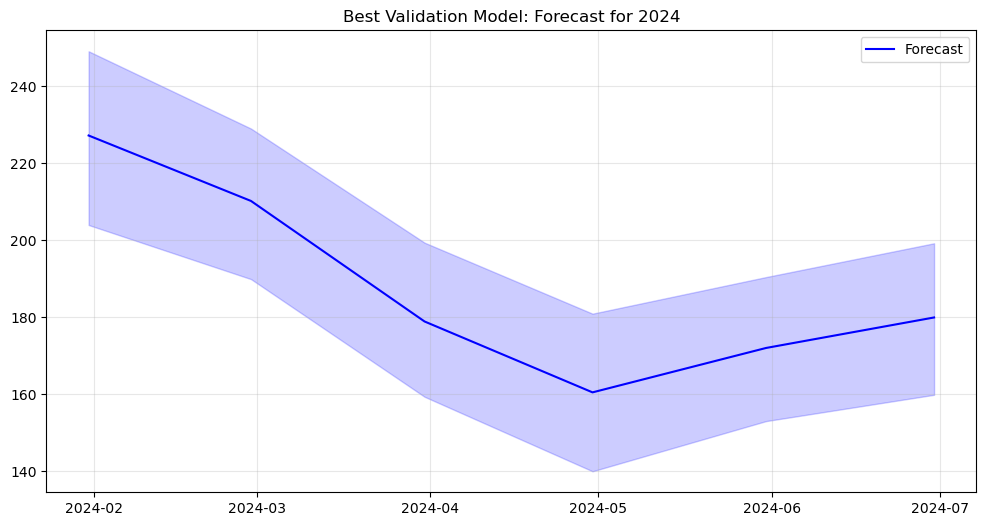

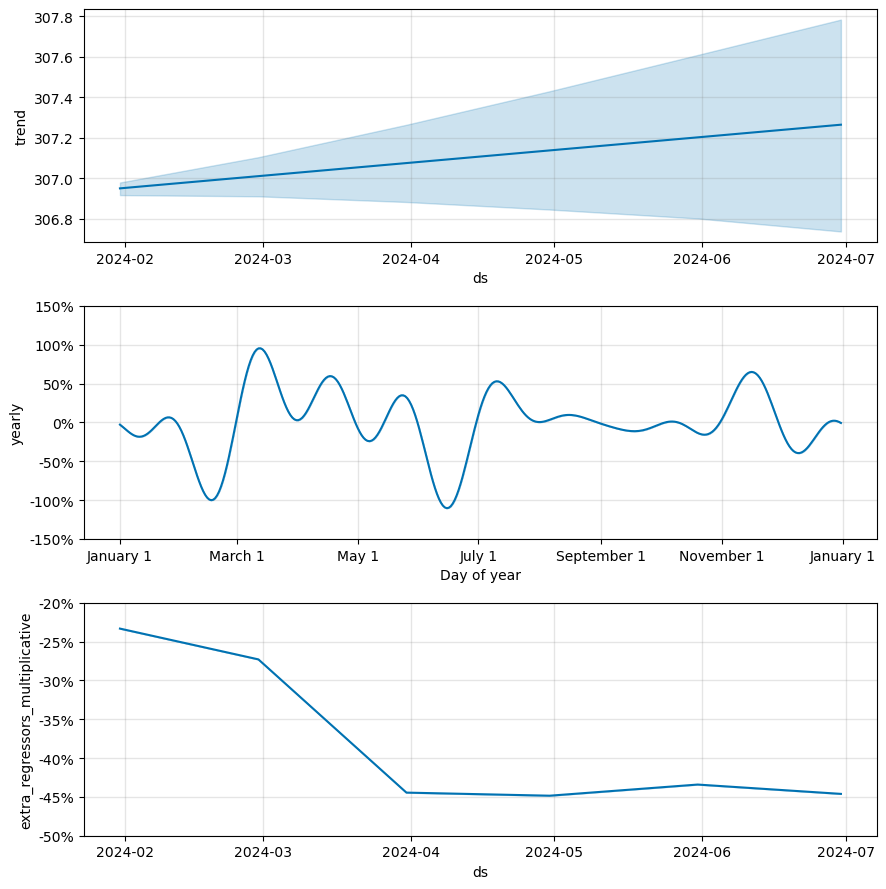

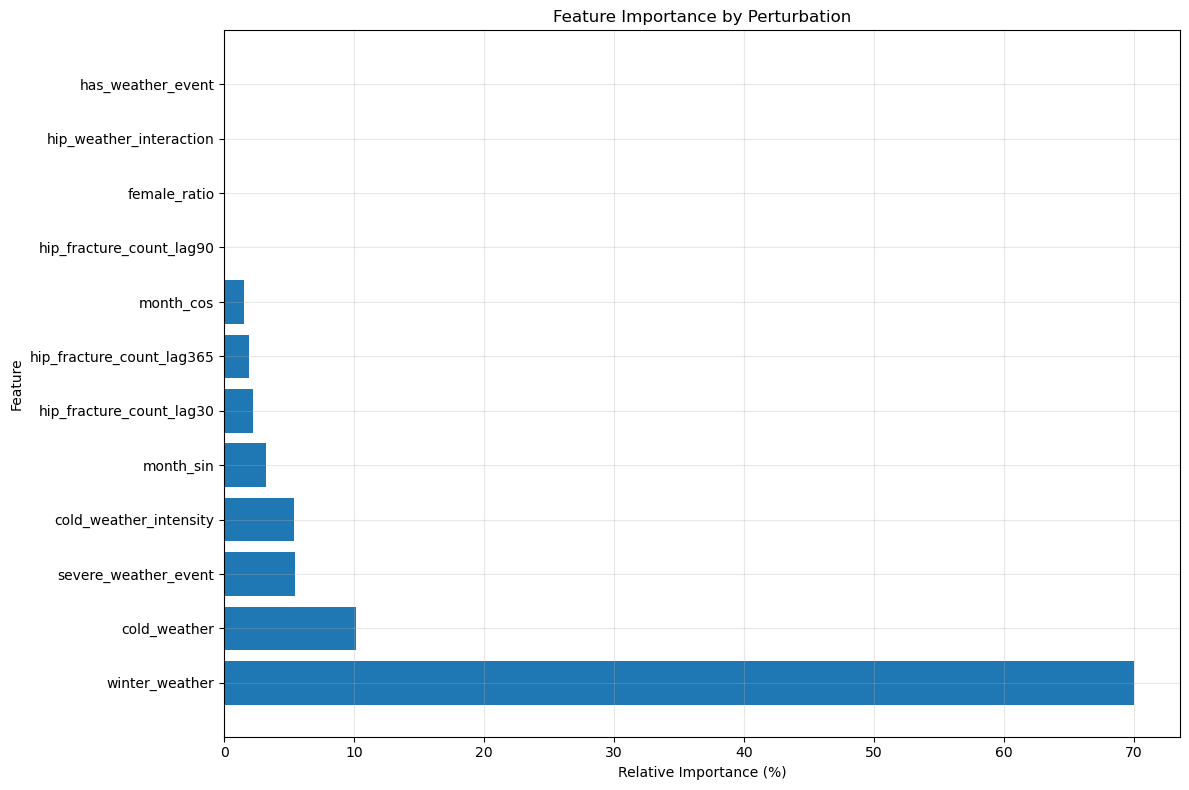

10:30:35 - cmdstanpy - INFO - Chain [1] start processing
10:30:35 - cmdstanpy - INFO - Chain [1] done processing



Training model on all data for comparison...

Full Model Performance on Unseen 2024 Data:
Mean Absolute Error: 102.73
Root Mean Squared Error: 103.39
R² Score: 0.0000

Monthly Actual and Forecasted Hip Fracture Rates (Full Model):
Month        Actual     Forecast   Lower 95%    Upper 95%    Diff       Diff %    
--------------------------------------------------------------------------------
2024-01      0.00       121.17     96.40        144.62       121.17     inf       %
2024-02      0.00       104.51     81.07        127.83       104.51     inf       %
2024-03      0.00       97.35      73.45        121.12       97.35      inf       %
2024-04      0.00       88.70      65.38        111.80       88.70      inf       %
2024-05      0.00       113.46     89.57        136.50       113.46     inf       %
2024-06      0.00       91.19      68.71        114.91       91.19      inf       %

Summary Statistics (Full Model):
Actual:    Min: 0.00, Max: 0.00, Mean: 0.00, Median: 0.00
Forecast

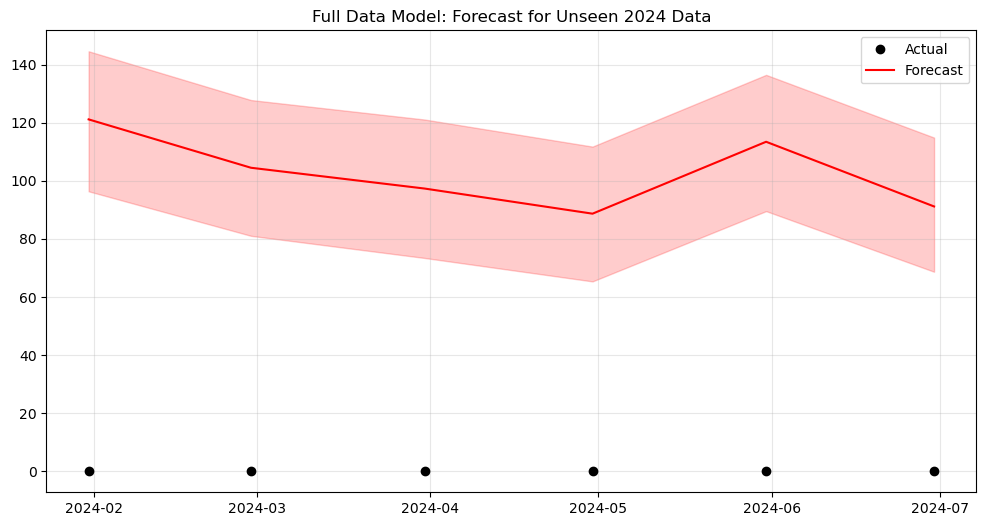

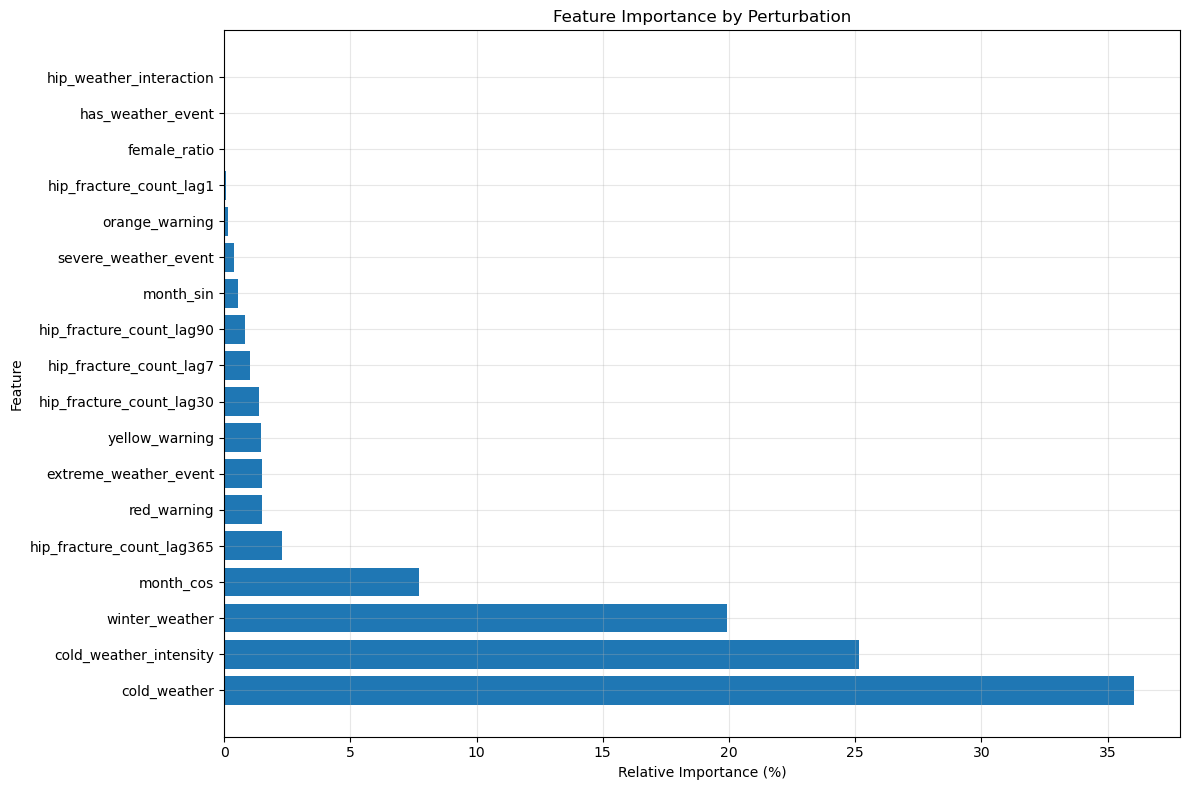

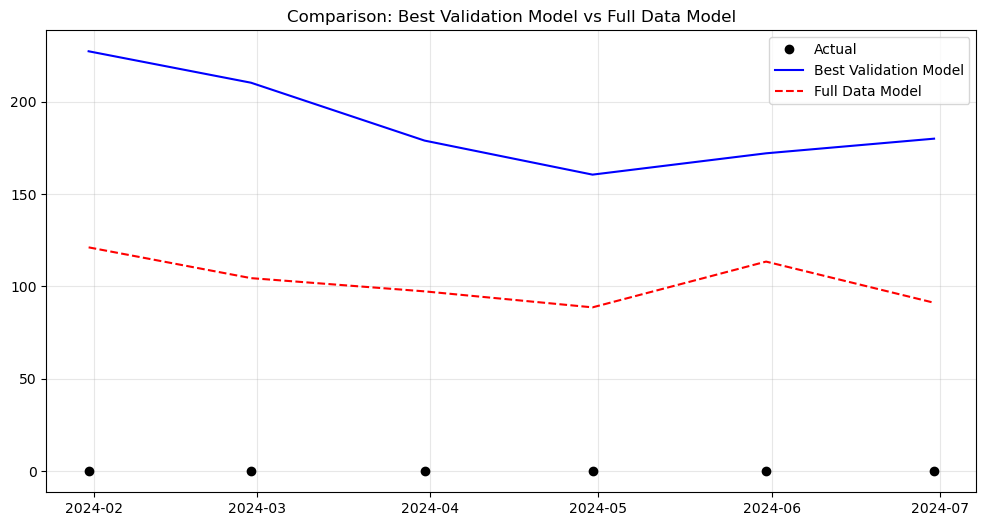

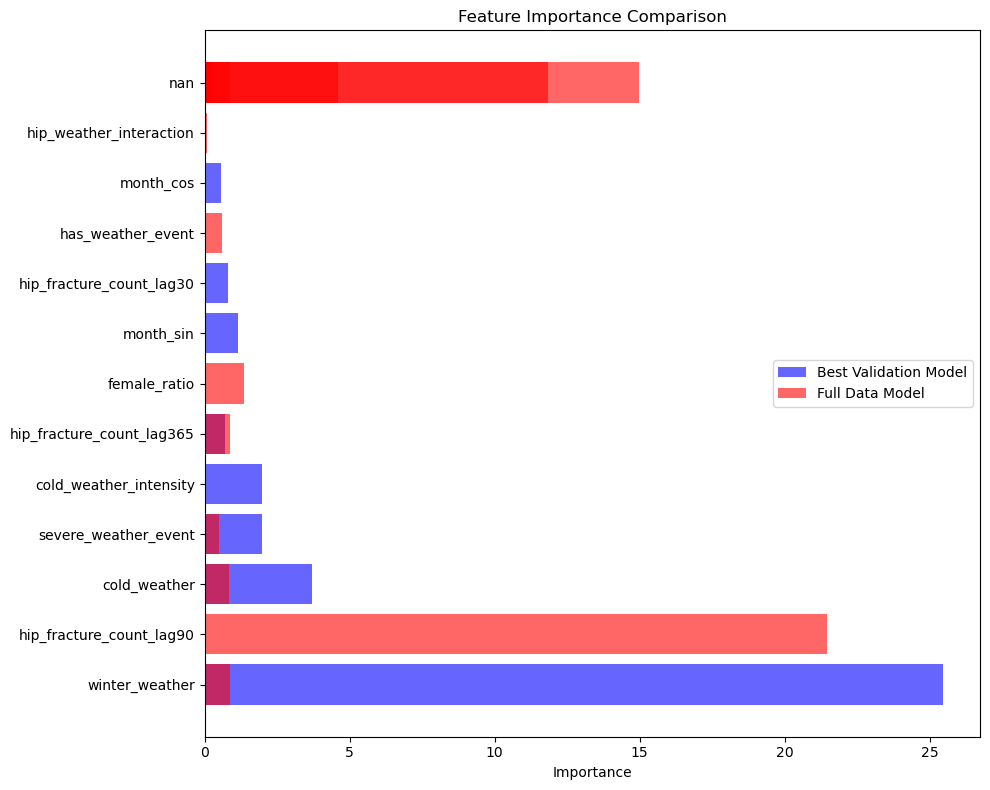

In [71]:
all_results = compare_models_on_unseen_data(
    merged_reg, 
    df_merged_with_weather,
    n_splits=12, 
    test_size_months=3
)